In [1]:
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
# from tensorflow.keras.mixed_precision import experimental as mixed_precision
from scipy.stats import sem

parentDir = os.path.dirname(os.path.abspath(os.getcwd()))
sys.path.append(os.path.join(os.getcwd(), "general_utils"))
# import file_management
sys.path.append(os.path.join(os.getcwd(), "Model_utils"))
import load_sparse
import models
import analysis_utils as utils
from math import pi

import h5py
import pickle as pkl
import other_billeh_utils
from scipy.ndimage import gaussian_filter
from numba import njit

%load_ext line_profiler

sns.set(style="ticks")
plt.rcParams['text.usetex'] = True

/tmp/ipykernel_3421000/902652848.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
2024-08-13 16:29:33.159793: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## DATA LOADING

In [2]:
cache_path = '/home/jgalvan/Desktop/Neurocoding/LM_V1_Billeh_model/Model_utils/.cache/lm_v1_network_v1_90000_lm_30000_E4_weight_factor_4.0.pkl'
with open(cache_path, 'rb') as f:
    networks, lgn_inputs, bkg_inputs = pkl.load(f)
    
ckpt_path = '/home/jgalvan/Desktop/Neurocoding/LM_V1_Billeh_model/Benchmark_models/v1_90000_lm_30000'
checkpoint_directory = tf.train.latest_checkpoint(ckpt_path)
print(f'Restoring checkpoint from {checkpoint_directory}...')

# Build the model
model = models.create_model(
    networks, 
    lgn_inputs, 
    bkg_inputs, 
    seq_len=1000,
    n_input=17400, 
    dtype=tf.float32, 
    input_weight_scale=1,
    interarea_weight_scale=1., 
    recurrent_dampening_factor=1,
    dampening_factor=1, 
    gauss_std=1, 
    lr_scale=1,
    train_recurrent_v1=True, 
    train_recurrent_lm=True, 
    train_input=True, 
    train_interarea_lm_v1=True,
    train_interarea_v1_lm=True,
    train_noise=True,
    batch_size=1, 
    pseudo_gauss=False, 
    use_state_input=True, 
    return_state=True,
    hard_reset=False,
    connected_areas=True,
    add_rate_metric=False, 
    max_delay=5, 
    # output_completed_valid_from_time=120, 
    # output_abstract_valid_from_time=100,
    )

model.build((1, 1000, 17400))

# Store the initial model variables that are going to be trained
model_variables_dict = {'Initial': {var.name: var.numpy().astype(np.float16) for var in model.trainable_variables}}
checkpoint = tf.train.Checkpoint(model=model)
checkpoint.restore(checkpoint_directory).expect_partial()#.assert_consumed()
model_variables_dict['Restored'] = {var.name: var.numpy().astype(np.float16) for var in model.trainable_variables}
model_variables_dict

Restoring checkpoint from /home/jgalvan/Desktop/Neurocoding/LM_V1_Billeh_model/Benchmark_models/v1_90000_lm_30000/ckpt-261...
###### COLUMN v1 ######


2024-08-13 16:29:41.091821: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


    > # Recurrent synapses: 26138775
    > # LGN input synapses 1368532
    > # BKG input synapses 90000
> lm to v1 interarea synapses 4404141
Init finished!!
###### COLUMN lm ######
    > # Recurrent synapses: 7803467
    > # LGN to lm input synapses 0
    > # BKG input synapses 30000
> v1 to lm interarea synapses 6300353
Init finished!!


{'Initial': {'v1_sparse_input_weights:0': array([0.597 , 0.597 , 0.597 , ..., 0.3323, 0.3323, 0.3323], dtype=float16),
  'lm_rest_of_brain_weights:0': array([0.1599, 0.1599, 0.1599, ..., 0.1614, 0.1614, 0.1614], dtype=float16),
  'v1_rest_of_brain_weights:0': array([0.1891, 0.1891, 0.1891, ..., 0.212 , 0.212 , 0.212 ], dtype=float16),
  'v1_sparse_recurrent_weights:0': array([5.020e-01, 9.458e-01, 2.393e-04, ..., 4.344e+00, 2.158e+00,
         0.000e+00], dtype=float16),
  'v1_sparse_interarea_weights_lm:0': array([0.000e+00, 0.000e+00, 0.000e+00, ..., 0.000e+00, 1.991e-03,
         1.192e-07], dtype=float16),
  'lm_sparse_recurrent_weights:0': array([3.004e+00, 5.603e-06, 1.346e+00, ..., 0.000e+00, 1.192e-07,
         1.192e-07], dtype=float16),
  'lm_sparse_interarea_weights_v1:0': array([0.000e+00, 7.749e-07, 1.353e-05, ..., 0.000e+00, 1.192e-07,
         0.000e+00], dtype=float16)},
 'Restored': {'v1_sparse_input_weights:0': array([0.597 , 0.597 , 0.597 , ..., 0.3323, 0.3323, 0.332

In [3]:
lm_to_v1_radius_ratio = 400/151.07

v1_path = '/home/jgalvan/Desktop/Neurocoding/LM_V1_Billeh_model/Benchmark_models/v1_90000_lm_30000/v1_features_df.csv'
# v1_path = '/home/jgalvan/Desktop/Neurocoding/LM_V1_Billeh_model/Simulation_results/v1_90000_lm_30000_E4_weight_factor_4.0/b_m4bo/Best_model/ckpt-261_results/v1_features_df.csv'
v1_core_df = pd.read_csv(v1_path, sep=' ')

v1_pop_names = other_billeh_utils.pop_names(networks['v1'])
v1_cell_types = [other_billeh_utils.pop_name_to_cell_type(pop_name) for pop_name in v1_pop_names]
v1_ei = ['e' if 'E' in cell_type else 'i' for cell_type in v1_cell_types]
v1_core_mask = other_billeh_utils.isolate_core_neurons(networks['v1'], n_selected_neurons=51978, data_dir='GLIF_network')
v1_core_indices = np.where(v1_core_mask)[0]
v1_core_df['tf_id'] = v1_core_indices

all_v1_neurons_df = pd.DataFrame({
    'tf_id': np.arange(len(v1_pop_names)),
    'pop_name': v1_pop_names,
    'cell_type': v1_cell_types,
    'ei': v1_ei,
    'tuning_angle': networks['v1']['tuning_angle'],
    'x': networks['v1']['x'],
    'y': networks['v1']['y'],
    'z': networks['v1']['z'],
    'azimuth': networks['v1']['x'] * 70/1000,
    'elevation': networks['v1']['z'] * 40/1000
})

v1_df = pd.merge(all_v1_neurons_df, v1_core_df, on=['tf_id', 'pop_name'], how='outer')
v1_df['area'] = 'v1'
v1_df['region'] = np.where(v1_df['tf_id'].isin(v1_core_indices), 'core', 'annulus')

lm_path = '/home/jgalvan/Desktop/Neurocoding/LM_V1_Billeh_model/Benchmark_models/v1_90000_lm_30000/lm_features_df.csv'
# lm_path = '/home/jgalvan/Desktop/Neurocoding/LM_V1_Billeh_model/Simulation_results/v1_90000_lm_30000_E4_weight_factor_4.0/b_m4bo/Best_model/ckpt-261_results/lm_features_df.csv'
lm_core_df = pd.read_csv(lm_path, sep=' ')
lm_pop_names = other_billeh_utils.pop_names(networks['lm'])
lm_cell_types = [other_billeh_utils.pop_name_to_cell_type(pop_name) for pop_name in lm_pop_names]
lm_ei = ['e' if 'E' in cell_type else 'i' for cell_type in lm_cell_types]
lm_core_mask = other_billeh_utils.isolate_core_neurons(networks['lm'], n_selected_neurons=7414, data_dir='GLIF_network')
lm_core_indices = np.where(lm_core_mask)[0]
lm_core_df['tf_id'] = lm_core_indices

# Create a DataFrame for all neurons
all_lm_neurons_df = pd.DataFrame({
    'tf_id': np.arange(len(lm_pop_names)),
    'pop_name': lm_pop_names,
    'cell_type': lm_cell_types,
    'ei': lm_ei,
    'tuning_angle': networks['lm']['tuning_angle'],
    'x': networks['lm']['x'],
    'y': networks['lm']['y'],
    'z': networks['lm']['z'],
    'azimuth': networks['lm']['x'] * lm_to_v1_radius_ratio * 70/1000,
    'elevation': networks['lm']['z'] * lm_to_v1_radius_ratio * 40/1000
})

lm_df = pd.merge(all_lm_neurons_df, lm_core_df, on=['tf_id', 'pop_name'], how='outer')
lm_df['area'] = 'lm'
lm_df['region'] = np.where(lm_df['tf_id'].isin(lm_core_indices), 'core', 'annulus')

df = pd.concat([v1_df, lm_df])
# can we set two indices: first the area and then the tf_id
df.set_index(['area', 'tf_id'], inplace=True)
# df.set_index('tf_id', inplace=True)
df.dropna(subset=['preferred_angle'], inplace=True)
df

pop_name cell_type ei  tuning_angle           x           y  \
area tf_id                                                               
v1   4431    e5Rbp4    L5 Exc  e      0.000000 -227.754333 -578.954834   
     4432    e5Rbp4    L5 Exc  e      0.059900   32.035698 -548.954407   
     4433    e5Rbp4    L5 Exc  e      0.119800 -332.630981 -602.166626   
     4434    e5Rbp4    L5 Exc  e      0.179700 -190.682373 -540.698242   
     4435    e5Rbp4    L5 Exc  e      0.239601  332.985382 -569.435669   
...             ...       ... ..           ...         ...         ...   
lm   29977  e6Ntsr1    L6 Exc  e    358.854218  -63.967518 -714.476074   
     29986  e6Ntsr1    L6 Exc  e    359.245453  -82.191101 -841.526978   
     29990  e6Ntsr1    L6 Exc  e    359.524933  -66.333992 -684.562439   
     29993  e6Ntsr1    L6 Exc  e    359.692596   73.521645 -662.949280   
     29995  e6Ntsr1    L6 Exc  e    359.776428  -37.134609 -692.997437   

                     z    azimuth  elevation  node_id  Ave_Rate(Hz)  \
area tf_id                                                            
v1   4431  -192.656769 -15.942803  -7.706271      0.0       3.66875   
     4432  -319.442719   2.242499 -12.777709      1.0       2.05625   
     4433   -38.666023 -23.284168  -1.546641      2.0       7.50625   
     4434  -199.981979 -13.347766  -7.999279      3.0       4.32500   
     4435   -76.783974  23.308977  -3.071359      4.0       5.79375   
...                ...        ...        ...      ...           ...   
lm   29977   71.134254 -11.856031   7.533912   7409.0       3.37500   
     29986  -78.064636 -15.233672  -8.267917   7410.0      14.43750   
     29990  -69.246002 -12.294643  -7.333925   7411.0       2.18750   
     29993  -62.211990  13.626836  -6.588945   7412.0       6.21250   
     29995  -49.214943  -6.882697  -5.212412   7413.0       4.55000   

            max_mean_rate(Hz)  preferred_angle       OSI       DSI  \
area tf_id                                                           
v1   4431            6.332199       357.905355  0.217318  0.087278   
     4432            3.474329       355.793379  0.197381  0.155597   
     4433           11.698303         0.514986  0.162365  0.088028   
     4434            7.543723         2.273434  0.227251  0.107165   
     4435            9.324759       359.289775  0.213660  0.056315   
...                       ...              ...       ...       ...   
lm   29977           4.968893       356.740688  0.184462  0.029458   
     29986          18.374609         0.487855  0.084023  0.027526   
     29990           3.730512       357.437073  0.229711  0.082632   
     29993          12.792756       354.284783  0.306661  0.144503   
     29995           9.236115         1.292028  0.315946  0.156924   

            firing_rate_sp region  
area tf_id                         
v1   4431         3.305556   core  
     4432         1.444444   core  
     4433         8.444444   core  
     4434         3.611111   core  
     4435         4.055556   core  
...                    ...    ...  
lm   29977        2.916667   core  
     29986       11.805556   core  
     29990        1.916667   core  
     29993        3.416667   core  
     29995        3.027778   core  

[45257 rows x 17 columns]

In [42]:
# #take a sample of the df but keep it ordered
# df = df.sample(frac=0.1).sort_index()
# df

## FUNCTIONS TOOLKIT

In [4]:
@njit
def fast_indices_masking(indices, target_tf_ids, source_tf_ids):
    target_tf_ids_set = set(target_tf_ids)
    source_tf_ids_set = set(source_tf_ids)
    mask = np.zeros(indices.shape[0], dtype=np.bool_)
    for k in range(indices.shape[0]):
        i, j = indices[k]
        if i in target_tf_ids_set and j in source_tf_ids_set:
            mask[k] = True
    return mask

## PREFERRED VS TUNING ANGLE HISTOGRAM|

V1 Percentage of responsive neurons: 44.22888888888889
V1 Mean difference between preferred and estimated tuning angle: 8.061810689435434
LM Percentage of responsive neurons: 18.17
LM Mean difference between preferred and estimated tuning angle: 7.447205213932886
1016
456


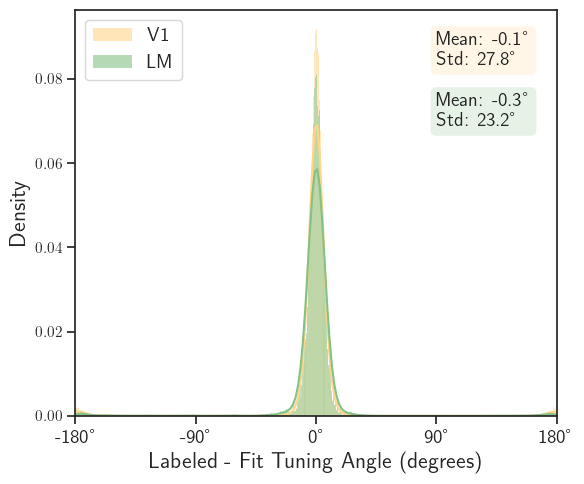

In [10]:
# plot an histogram with the variation of the tuning angle
v1_tuning_angles_diff = v1_df['tuning_angle'] - v1_df['preferred_angle']
v1_responsive_neurons_mask = np.logical_not(np.isnan(v1_tuning_angles_diff))
v1_tuning_angles_diff = v1_tuning_angles_diff[v1_responsive_neurons_mask]
v1_tuning_angles_diff = np.where(v1_tuning_angles_diff > 180, v1_tuning_angles_diff - 360, v1_tuning_angles_diff)
v1_tuning_angles_diff = np.where(v1_tuning_angles_diff < -180, v1_tuning_angles_diff + 360, v1_tuning_angles_diff)
print('V1 Percentage of responsive neurons:', np.sum(v1_responsive_neurons_mask) / len(v1_responsive_neurons_mask) * 100)
print('V1 Mean difference between preferred and estimated tuning angle:', np.nanmean(np.abs(v1_tuning_angles_diff)))

lm_tuning_angles_diff = lm_df['tuning_angle'] - lm_df['preferred_angle']
lm_responsive_neurons_mask = np.logical_not(np.isnan(lm_tuning_angles_diff))
lm_tuning_angles_diff = lm_tuning_angles_diff[lm_responsive_neurons_mask]
lm_tuning_angles_diff = np.where(lm_tuning_angles_diff > 180, lm_tuning_angles_diff - 360, lm_tuning_angles_diff)
lm_tuning_angles_diff = np.where(lm_tuning_angles_diff < -180, lm_tuning_angles_diff + 360, lm_tuning_angles_diff)
print('LM Percentage of responsive neurons:', np.sum(lm_responsive_neurons_mask) / len(lm_responsive_neurons_mask) * 100)
print('LM Mean difference between preferred and estimated tuning angle:', np.nanmean(np.abs(lm_tuning_angles_diff)))

def plot_tuning_angle_variation(V1_diff, LM_diff, path=''):

    fig, ax = plt.subplots(1, 1, figsize=(6, 5))

    # Plot the first distribution
    V1_diff = V1_diff[~np.isnan(V1_diff)]
    NBR_BINS = utils.freedman_diaconis(V1_diff, returnas="bins")
    print(NBR_BINS)
    sns.histplot(V1_diff, bins=NBR_BINS, kde=True, ax=ax, color='#ffd588', label='V1', alpha=0.6, stat='density')
    # Plot the second distribution
    LM_diff = LM_diff[~np.isnan(LM_diff)]
    NBR_BINS = utils.freedman_diaconis(LM_diff, returnas="bins")
    print(NBR_BINS)
    sns.histplot(LM_diff, bins=NBR_BINS, kde=True, ax=ax, color='#84c184', label='LM', alpha=0.6, stat='density')
    
    # Include as text the mean and std of the difference for each distribution
    box = dict(boxstyle='round', facecolor='#ffd588', alpha=0.2)
    ax.text(0.75, 0.9, f'Mean: {np.mean(V1_diff):.1f}°\nStd: {np.std(V1_diff):.1f}°', horizontalalignment='left', 
            verticalalignment='center', transform=ax.transAxes, fontsize=14, bbox=box)
    box = dict(boxstyle='round', facecolor='#84c184', alpha=0.2)
    ax.text(0.75, 0.75, f'Mean: {np.mean(LM_diff):.1f}°\nStd: {np.std(LM_diff):.1f}°', horizontalalignment='left',
            verticalalignment='center', transform=ax.transAxes, fontsize=14, bbox=box)
    
    # Customize the plot
    xticks = np.arange(-180, 181, 90)
    ax.set_xticks(xticks)
    ax.set_xticklabels([str(x)+'°' for x in xticks], fontsize=14)
    # ax.set_yticks(list(ax.get_yticks().astype(int)))  # Set the ticks explicitly
    # ax.set_yticklabels(ax.get_yticks(), fontsize=14)  # Set the tick labels
    ax.set_xlim(-180, 180)
    ax.set_xlabel('Labeled - Fit Tuning Angle (degrees)', fontsize=16)
    ax.set_ylabel('Density', fontsize=16)
    # plt.title(f'{self.area}', fontsize=16)
    plt.legend(loc='upper left', fontsize=14)
    plt.tight_layout()
    plt.savefig(os.path.join(path, f'V1_LM_tuning_angle_variation.png'), dpi=900, transparent=True)
    plt.show()      
#     plt.close()
        
plot_tuning_angle_variation(v1_tuning_angles_diff, lm_tuning_angles_diff, path='')

## WEIGHTS DISTRIBUTION IN TARGET NEURON COORDINATES

In [45]:
### DATA PREPARATION
source_area = 'v1'
target_area = 'v1'
cell_types = ['e', 'i']
source_cell_type = 'e'
target_cell_type = 'e'
source_df = df.loc[source_area]
target_df = df.loc[target_area]
# Compute voltage scale
voltage_scale = (networks[target_area]['node_params']['V_th'] - networks[target_area]['node_params']['E_L']).astype(np.float32)
# Determine the correct indices and variable key based on the source and target areas
if source_area == target_area:
    variable_key = f'{target_area}_sparse_recurrent_weights:0'
    indices = networks[target_area]["synapses"]["indices"].astype(np.int32)
    source_cell_types = cell_types
else:
    variable_key = f'{target_area}_sparse_interarea_weights_{source_area}:0'
    indices = networks[target_area]['interarea_synapses'][source_area]["indices"].astype(np.int32)
    source_cell_types = ['e']
# Calculate the voltage scale for node IDs
node_type_ids = networks[target_area]['node_type_ids']
# Select source and target IDs
source_tf_ids = source_df.index[source_df['ei'] == source_cell_type].astype(np.int32).values
target_tf_ids = target_df.index[(target_df['ei'] == target_cell_type) & (target_df['region'] == 'core')].astype(np.int32).values
# Create sets for fast lookup
mask = fast_indices_masking(indices, target_tf_ids, source_tf_ids)
selected_indices = indices[mask]
target_indices = selected_indices[:, 0]
source_indices = selected_indices[:, 1]
# Mask voltage_scale_node_ids first
voltage_scale_node_ids = voltage_scale[node_type_ids[target_indices]]
initial_value_masked = model_variables_dict['Initial'][variable_key][mask] * voltage_scale_node_ids
final_value_masked = model_variables_dict['Restored'][variable_key][mask] * voltage_scale_node_ids
# Calculate tuning angle differences
source_tuning_angles = source_df.loc[source_indices, 'preferred_angle'].values
target_tuning_angles = target_df.loc[target_indices, 'preferred_angle'].values
tuning_angle_diff = np.abs(source_tuning_angles - target_tuning_angles)
tuning_angle_diff = np.minimum(tuning_angle_diff, 360 - tuning_angle_diff)
# Calculate differences in coordinates
source_azimuth = source_df.loc[source_indices, 'azimuth'].values
target_azimuth = target_df.loc[target_indices, 'azimuth'].values
source_elevation = source_df.loc[source_indices, 'elevation'].values
target_elevation = target_df.loc[target_indices, 'elevation'].values
diff_x = source_azimuth - target_azimuth
diff_z = source_elevation - target_elevation
# rotate to the axis of target neuron tuning angle
target_tuning_angle_rad = np.radians(target_tuning_angles)
cos_angles = np.cos(target_tuning_angle_rad + pi)
sin_angles = np.sin(target_tuning_angle_rad + pi)
diff_x_rot = diff_z * sin_angles + diff_x * cos_angles
diff_z_rot = diff_z * cos_angles - diff_x * sin_angles

/tmp/ipykernel_3011076/1141615495.py:96: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


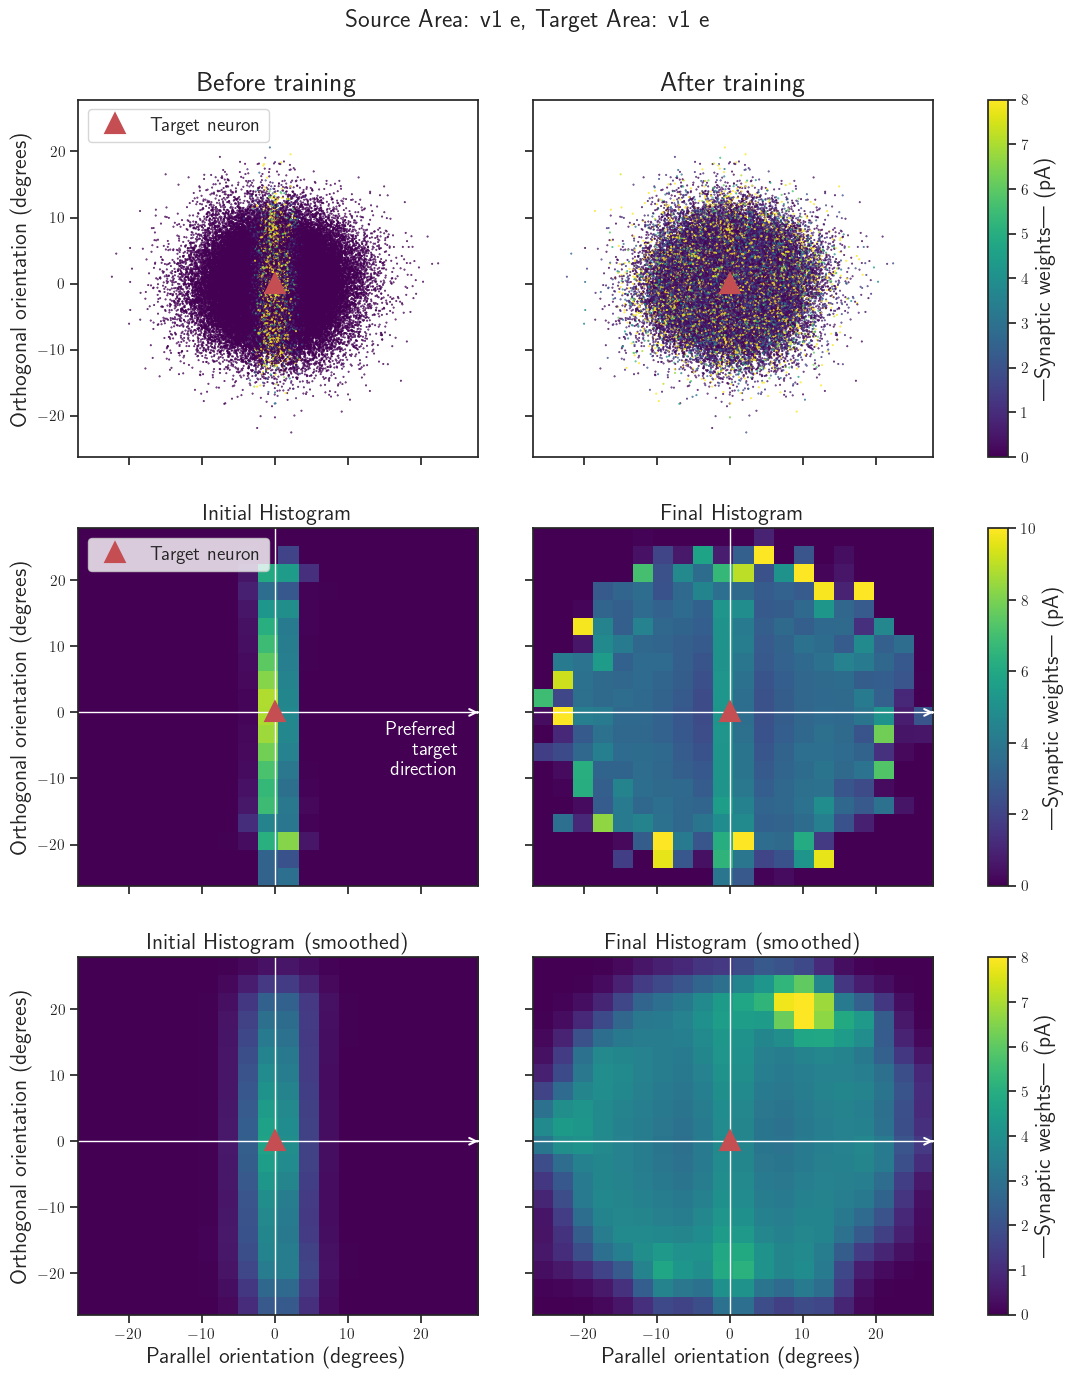

In [46]:
# Now represent the weights as a function of the difference in coordinates
fig = plt.figure(figsize=(12, 15))
gs = gridspec.GridSpec(3, 3, width_ratios=[1, 1, 0.05], wspace=0.2, hspace=0.2)

ax0 = plt.subplot(gs[0, 0])
ax1 = plt.subplot(gs[0, 1], sharex=ax0, sharey=ax0)
# Randomly select indices to sample
n_samples = 100000
random_indices = np.random.choice(len(diff_x_rot), n_samples, replace=False)
# Initial scatter plot
scatter_initial = ax0.scatter(diff_x_rot[random_indices], diff_z_rot[random_indices], c=initial_value_masked[random_indices], 
                              cmap='viridis', s=0.2, alpha=1, vmin=0, vmax=8)
ax0.set_title('Before training', fontsize=20)
ax0.set_ylabel('Orthogonal orientation (degrees)', fontsize=16)
# Final scatter plot
scatter_final = ax1.scatter(diff_x_rot[random_indices], diff_z_rot[random_indices], c=final_value_masked[random_indices], 
                            cmap='viridis', s=0.2, alpha=1, vmin=0, vmax=8)
ax1.set_title('After training', fontsize=20)
scatter_cbar = plt.colorbar(scatter_final, cax=plt.subplot(gs[0, 2]))
scatter_cbar.set_label('|Synaptic weights| (pA)', fontsize=16)

# Create 2D histograms
bins = 20  # Number of bins in each dimension
# Initial histogram
H_initial, xedges_initial, yedges_initial = np.histogram2d(diff_x_rot, diff_z_rot, bins=bins, weights=initial_value_masked)
count_initial, _, _ = np.histogram2d(diff_x_rot, diff_z_rot, bins=bins)
H_initial = np.divide(H_initial, count_initial, out=np.zeros_like(H_initial), where=count_initial != 0)
# Final histogram
H_final, xedges_final, yedges_final = np.histogram2d(diff_x_rot, diff_z_rot, bins=bins, weights=final_value_masked)
count_final, _, _ = np.histogram2d(diff_x_rot, diff_z_rot, bins=bins)
H_final = np.divide(H_final, count_final, out=np.zeros_like(H_final), where=count_final != 0)

# Plot initial histogram with shared color scale
ax2 = plt.subplot(gs[1, 0], sharex=ax0, sharey=ax0)
im_initial = ax2.imshow(H_initial.T, origin='lower', 
                            extent=[xedges_initial[0], xedges_initial[-1], yedges_initial[0], yedges_initial[-1]], 
                            aspect='auto', cmap='viridis', vmin=0, vmax=10)
ax2.set_title('Initial Histogram', fontsize=16)
ax2.set_ylabel('Orthogonal orientation (degrees)', fontsize=16)
# Plot final histogram with shared color scale
ax3 = plt.subplot(gs[1, 1], sharex=ax0, sharey=ax0)
im_final = ax3.imshow(H_final.T, origin='lower', 
                        extent=[xedges_final[0], xedges_final[-1], yedges_final[0], yedges_final[-1]], 
                        aspect='auto', cmap='viridis', vmin=0, vmax=10)
ax3.set_title('Final Histogram', fontsize=16)
cb_final = plt.colorbar(im_final, cax=plt.subplot(gs[1, 2]))
cb_final.set_label('|Synaptic weights| (pA)', fontsize=16)

# Apply Gaussian filter to histograms
sigma = 1  # Standard deviation for Gaussian kernel
H_initial_filtered = gaussian_filter(H_initial, sigma=sigma)
H_final_filtered = gaussian_filter(H_final, sigma=sigma)
# Plot initial histogram with Gaussian filter applied
ax4 = plt.subplot(gs[2, 0], sharex=ax0, sharey=ax0)
im_initial_filtered = ax4.imshow(H_initial_filtered.T, origin='lower', 
                                    extent=[xedges_initial[0], xedges_initial[-1], yedges_initial[0], yedges_initial[-1]], 
                                    aspect='auto', cmap='viridis', vmin=0, vmax=8) 
ax4.set_title('Initial Histogram (smoothed)', fontsize=16)
ax4.set_xlabel('Parallel orientation (degrees)', fontsize=16)
ax4.set_ylabel('Orthogonal orientation (degrees)', fontsize=16)
# Plot final histogram with Gaussian filter applied
ax5 = plt.subplot(gs[2, 1], sharex=ax0, sharey=ax0)
im_final_filtered = ax5.imshow(H_final_filtered.T, origin='lower', 
                                    extent=[xedges_final[0], xedges_final[-1], yedges_final[0], yedges_final[-1]], 
                                    aspect='auto', cmap='viridis', vmin=0, vmax=8)
ax5.set_title('Final Histogram (smoothed)', fontsize=16)
ax5.set_xlabel('Parallel orientation (degrees)', fontsize=16)
cb_final_filtered = plt.colorbar(im_final_filtered, cax=plt.subplot(gs[2, 2]))
cb_final_filtered.set_label(r'|Synaptic weights| (pA)', fontsize=16)
# Draw arrow and text for each subplot at y=0
for ax in [ax2, ax3, ax4, ax5]:
    ax.axvline(0, color='white', lw=1)
    ax.axhline(0, color='white', lw=1)
    ax.annotate('', xy=(ax.get_xlim()[1], 0), xytext=(ax.get_xlim()[1]-0.1, 0),
                arrowprops=dict(arrowstyle='->', color='white', lw=1.5))
    if ax == ax2:
        # Position for the centered text at the right end of the x-axis
        x_right = x_right = ax.get_xlim()[1] - 0.05 * (ax.get_xlim()[1] - ax.get_xlim()[0])  # Move left by 10% of x-axis range
        y_position = -0.025 * (ax.get_ylim()[1] - ax.get_ylim()[0])
        ax.text(x_right, y_position,
                'Preferred \n target \n direction', color='white', ha='right', va='top', fontsize=14, weight='bold')
# Hide y ticks for specific subplots (e.g., ax1, ax3, ax5)
for ax in [ax1, ax3, ax5]:
    ax.tick_params(axis='y', labelleft=False)
# Hide x ticks for specific subplots (e.g., ax0, ax1, ax2, ax3)
for ax in [ax0, ax1, ax2, ax3]:
    ax.tick_params(axis='x', labelbottom=False)

for ax in [ax0, ax1, ax2, ax3, ax4, ax5]:
    ax.plot(0, 0, 'r^', markersize=12, markeredgewidth=3, label='Target neuron')
ax0.legend(loc='upper left', fontsize=14)
ax2.legend(loc='upper left', fontsize=14)

fig.suptitle(f'Source Area: {source_area} {source_cell_type}, Target Area: {target_area} {target_cell_type}', fontsize=18)
fig.subplots_adjust(top=0.92)
plt.tight_layout()
plt.show()

## WEIGHTS DISTRIBUTION FOR PARALLEL, PERPENDICULAR AND OPPOSITTE SOURCE NEURONS


e - e : Mean value of parallel histogram: 11.586149215698242
e - e : Mean value of perpendicular histogram: 0.8943551778793335
e - e : Mean value of opposite histogram: 3.698432445526123

e - i : Mean value of parallel histogram: 13.891080856323242
e - i : Mean value of perpendicular histogram: 1.773342251777649
e - i : Mean value of opposite histogram: 3.7053050994873047

i - e : Mean value of parallel histogram: 2.355879545211792
i - e : Mean value of perpendicular histogram: 13.0377197265625
i - e : Mean value of opposite histogram: 3.529562473297119

i - i : Mean value of parallel histogram: 5.0266218185424805
i - i : Mean value of perpendicular histogram: 12.684896469116211
i - i : Mean value of opposite histogram: 5.195391654968262


/home/jgalvan/.conda/envs/predictive_coding_tf212/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


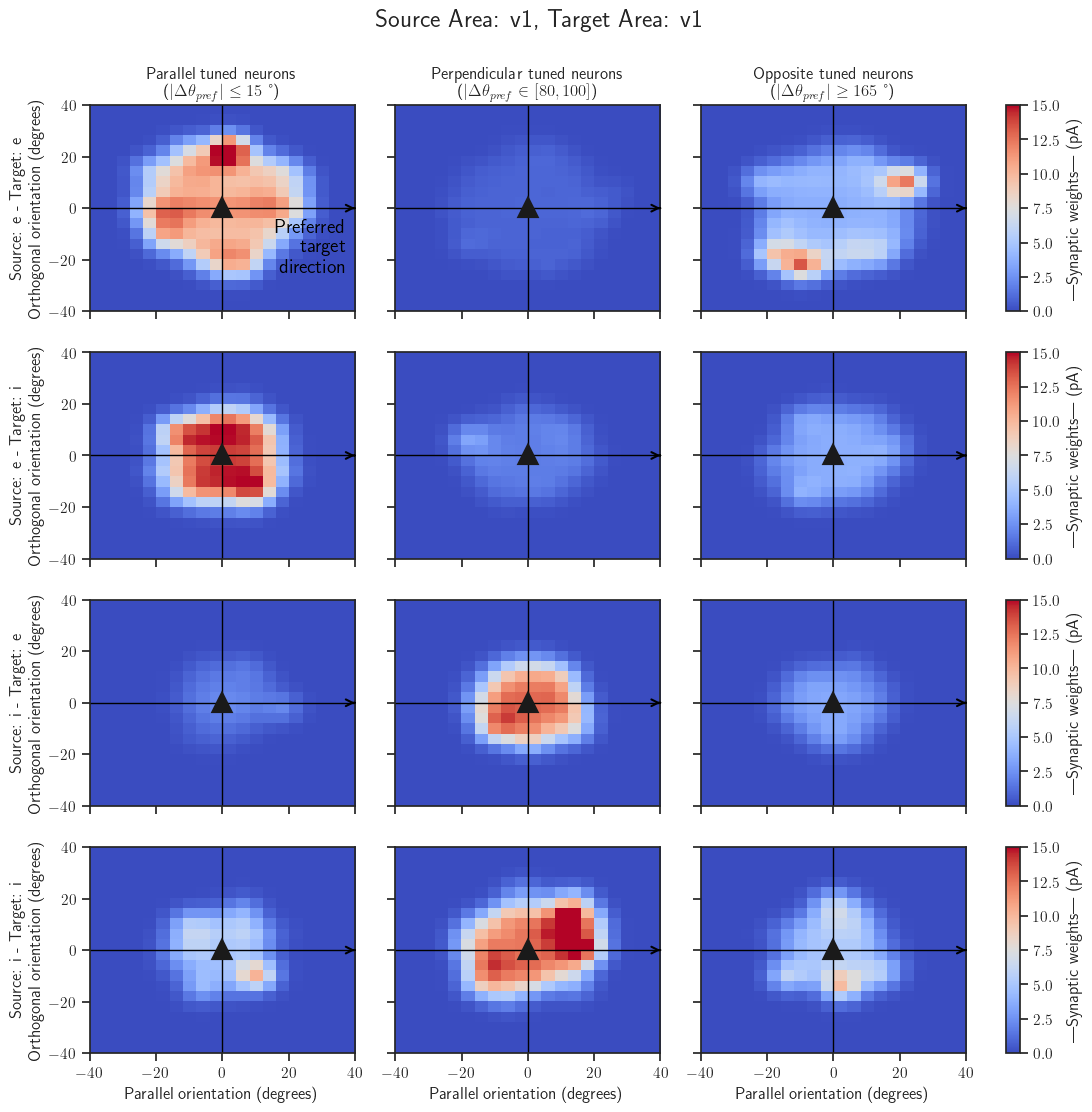


e - e : Mean value of parallel histogram: 3.586714506149292
e - e : Mean value of perpendicular histogram: 1.1197320222854614
e - e : Mean value of opposite histogram: 1.690388560295105

e - i : Mean value of parallel histogram: 6.268343448638916
e - i : Mean value of perpendicular histogram: 2.0197362899780273
e - i : Mean value of opposite histogram: 3.949474334716797


/home/jgalvan/.conda/envs/predictive_coding_tf212/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


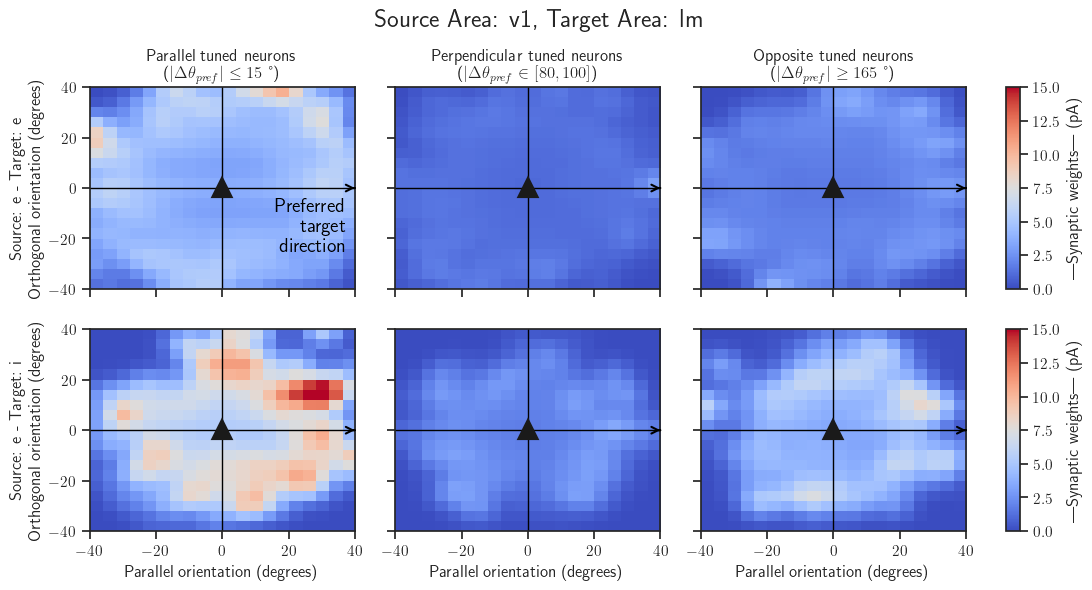


e - e : Mean value of parallel histogram: 13.00405216217041
e - e : Mean value of perpendicular histogram: 0.6564314365386963
e - e : Mean value of opposite histogram: 5.764324188232422

e - i : Mean value of parallel histogram: 11.363862037658691
e - i : Mean value of perpendicular histogram: 1.5184260606765747
e - i : Mean value of opposite histogram: 5.425929546356201


/home/jgalvan/.conda/envs/predictive_coding_tf212/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


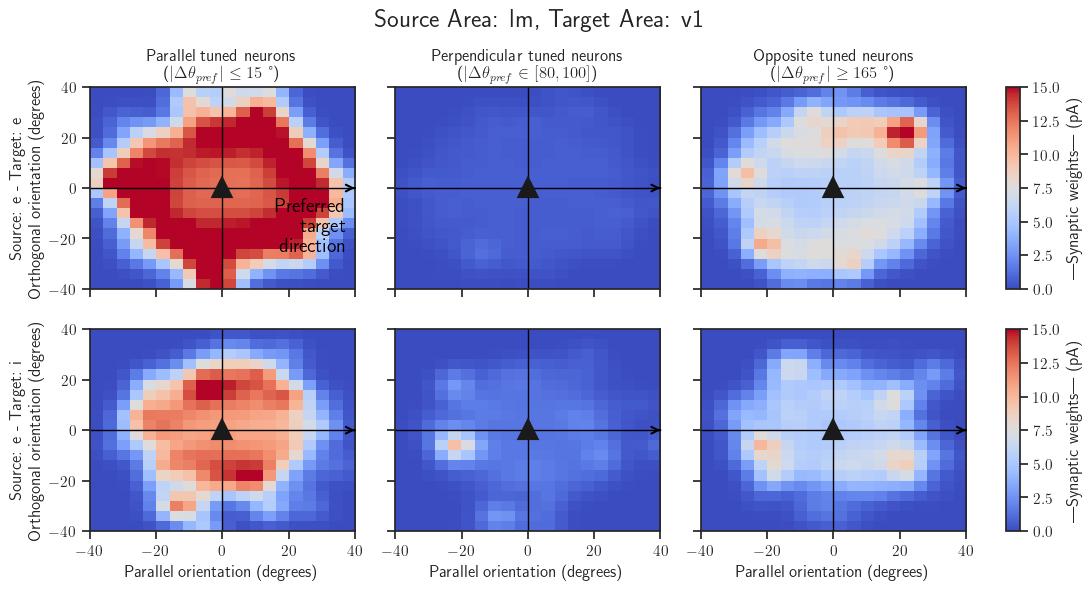


e - e : Mean value of parallel histogram: 6.5668721199035645
e - e : Mean value of perpendicular histogram: 0.7729359865188599
e - e : Mean value of opposite histogram: 1.2159907817840576

e - i : Mean value of parallel histogram: 12.389195442199707
e - i : Mean value of perpendicular histogram: 2.942427158355713
e - i : Mean value of opposite histogram: 3.4085140228271484

i - e : Mean value of parallel histogram: 6.297168254852295
i - e : Mean value of perpendicular histogram: 8.042798042297363
i - e : Mean value of opposite histogram: 6.373294830322266

i - i : Mean value of parallel histogram: 7.479587554931641
i - i : Mean value of perpendicular histogram: 9.91247272491455
i - i : Mean value of opposite histogram: 6.4376912117004395


/home/jgalvan/.conda/envs/predictive_coding_tf212/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


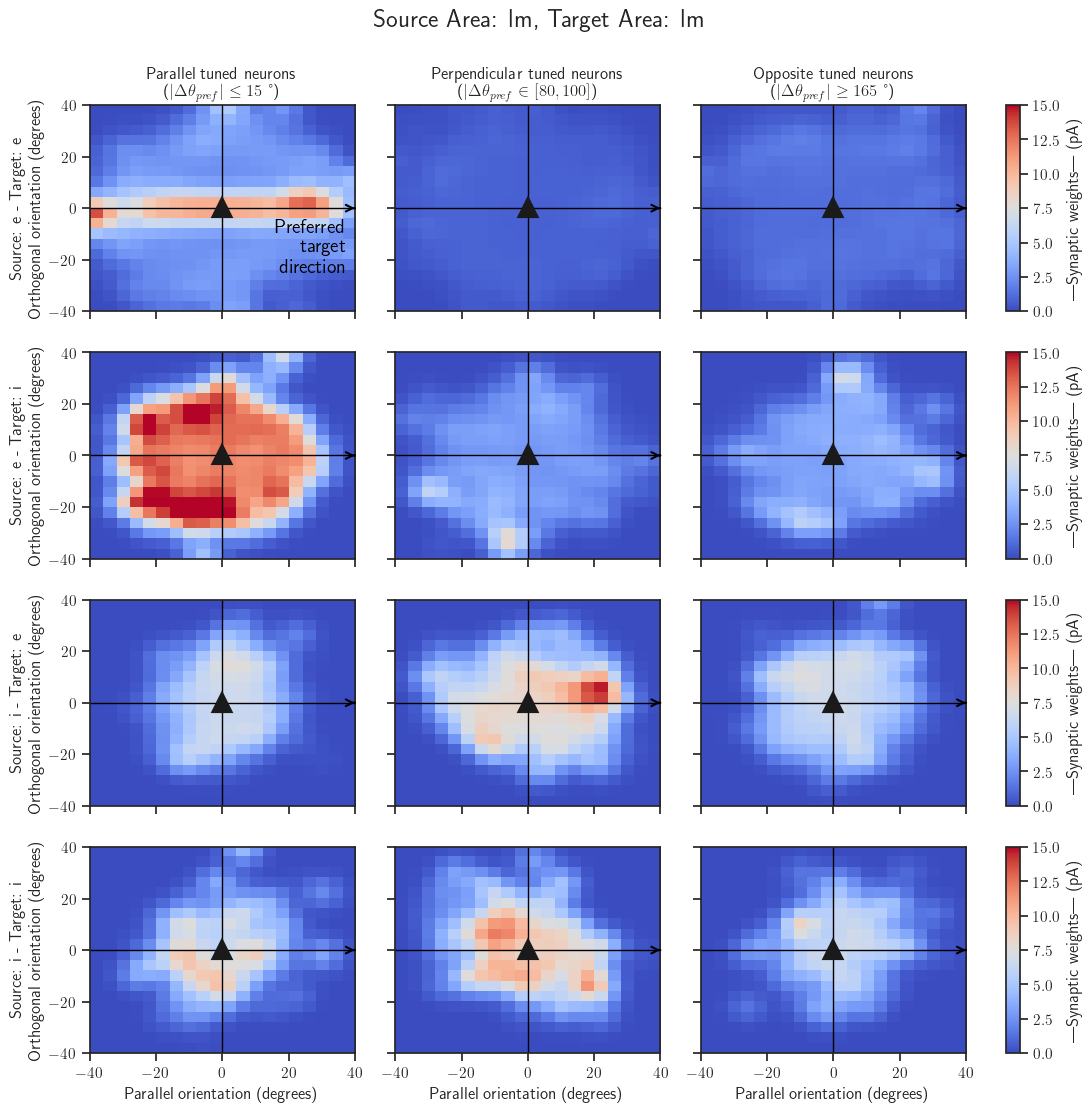

In [47]:
areas = ['v1', 'lm']
target_cell_types = ['e', 'i']

for source_area in areas:
    source_df = df.loc[source_area].copy()    
    for target_area in areas:
        target_df = df.loc[target_area].copy()
        voltage_scale = (networks[target_area]['node_params']['V_th'] - networks[target_area]['node_params']['E_L']).astype(np.float32)
        if source_area == target_area:
            variable_key = f'{target_area}_sparse_recurrent_weights:0'
            indices = networks[target_area]["synapses"]["indices"].astype(np.int32)
            source_cell_types = ['e', 'i']
        else:
            variable_key = f'{target_area}_sparse_interarea_weights_{source_area}:0'
            indices = networks[target_area]['interarea_synapses'][source_area]["indices"].astype(np.int32)
            source_cell_types = ['e']
        # Calculate the voltage scale for node IDs
        node_type_ids = networks[target_area]['node_type_ids']

        fig = plt.figure(figsize=(12, 6 * len(source_cell_types)), constrained_layout=True)
        if len(source_cell_types) * len(target_cell_types) == 4:
            top_title_space = 0.9
        else:
            top_title_space = 0.85
        gs = gridspec.GridSpec(len(source_cell_types) * len(target_cell_types), 4, width_ratios=[1, 1, 1, 0.05], top=top_title_space, wspace=0.2, hspace=0.2)
        plot_index = 0
        for row, source_cell_type in enumerate(source_cell_types):
            # Select source and target IDs
            source_tf_ids = source_df.index[(source_df['ei'] == source_cell_type) & (source_df['region'] == 'core') & (source_df['OSI'] > 0.2)].astype(np.int32).values
            for col, target_cell_type in enumerate(target_cell_types):
                target_tf_ids = target_df.index[(target_df['ei'] == target_cell_type) & (target_df['region'] == 'core')].astype(np.int32).values
                # Create sets for fast lookup
                mask = fast_indices_masking(indices, target_tf_ids, source_tf_ids)
                selected_indices = indices[mask]
                target_indices = selected_indices[:, 0]
                source_indices = selected_indices[:, 1]
                # Mask voltage_scale_node_ids first
                voltage_scale_node_ids = voltage_scale[node_type_ids[target_indices]]
                initial_value_masked = np.abs(model_variables_dict['Initial'][variable_key][mask] * voltage_scale_node_ids)
                final_value_masked = np.abs(model_variables_dict['Restored'][variable_key][mask] * voltage_scale_node_ids)
                # Calculate tuning angle differences
                source_tuning_angles = source_df.loc[source_indices, 'preferred_angle'].values
                target_tuning_angles = target_df.loc[target_indices, 'preferred_angle'].values
                tuning_angle_diff = np.abs(source_tuning_angles - target_tuning_angles)
                tuning_angle_diff = np.minimum(tuning_angle_diff, 360 - tuning_angle_diff)
                # Calculate differences in coordinates
                source_azimuth = source_df.loc[source_indices, 'azimuth'].values
                target_azimuth = target_df.loc[target_indices, 'azimuth'].values
                source_elevation = source_df.loc[source_indices, 'elevation'].values
                target_elevation = target_df.loc[target_indices, 'elevation'].values
                diff_x = source_azimuth - target_azimuth
                diff_z = source_elevation - target_elevation
                # rotate to the axis of target neuron tuning angle
                target_tuning_angle_rad = np.radians(target_tuning_angles)
                cos_angles = np.cos(target_tuning_angle_rad + pi)
                sin_angles = np.sin(target_tuning_angle_rad + pi)
                diff_x_rot = diff_z * sin_angles + diff_x * cos_angles
                diff_z_rot = diff_z * cos_angles - diff_x * sin_angles
                # Distinghish between parallel, orthogonal and opposite tuning angles
                # Parallel
                parallel_tuning_mask = tuning_angle_diff < 15
                parallel_diff_x = diff_x_rot[parallel_tuning_mask]
                parallel_diff_z = diff_z_rot[parallel_tuning_mask]
                parallel_final_value_masked = final_value_masked[parallel_tuning_mask]
                # Orthogonal
                orthogonal_tuning_mask = np.logical_and(tuning_angle_diff > 80, tuning_angle_diff < 100)
                orthogonal_diff_x = diff_x_rot[orthogonal_tuning_mask]
                orthogonal_diff_z = diff_z_rot[orthogonal_tuning_mask]
                orthogonal_final_value_masked = final_value_masked[orthogonal_tuning_mask]
                # Opposite
                opposite_tuning_mask = tuning_angle_diff > 165
                opposite_diff_x = diff_x_rot[opposite_tuning_mask]
                opposite_diff_z = diff_z_rot[opposite_tuning_mask]
                opposite_final_value_masked = final_value_masked[opposite_tuning_mask]

                bins = 20
                area_dimensions = [[-40, 40], [-40, 40]]
                # Parallel
                H_parallel, xedges_parallel, yedges_parallel = np.histogram2d(parallel_diff_z, parallel_diff_x, bins=bins, range=area_dimensions, weights=parallel_final_value_masked)
                count_parallel, _, _ = np.histogram2d(parallel_diff_z, parallel_diff_x, range=area_dimensions, bins=bins)
                H_parallel = np.divide(H_parallel, count_parallel, out=np.zeros_like(H_parallel), where=count_parallel != 0)
                # Orthogonal
                H_perpendicular, xedges_perpendicular, yedges_perpendicular = np.histogram2d(orthogonal_diff_z, orthogonal_diff_x, bins=bins, range=area_dimensions, weights=orthogonal_final_value_masked)
                count_perpendicular, _, _ = np.histogram2d(orthogonal_diff_z, orthogonal_diff_x, range=area_dimensions, bins=bins)
                H_perpendicular = np.divide(H_perpendicular, count_perpendicular, out=np.zeros_like(H_perpendicular), where=count_perpendicular != 0)
                # Opposite
                H_opp, xedges_opp, yedges_opp = np.histogram2d(opposite_diff_z, opposite_diff_x, bins=bins, range=area_dimensions, weights=opposite_final_value_masked)
                count_opp, _, _ = np.histogram2d(opposite_diff_z, opposite_diff_x, range=area_dimensions, bins=bins)
                H_opp = np.divide(H_opp, count_opp, out=np.zeros_like(H_opp), where=count_opp != 0)
                # Apply Gaussian filter to histograms
                sigma = 1
                H_parallel_filtered = gaussian_filter(H_parallel, sigma=sigma)
                H_perpendicular_filtered = gaussian_filter(H_perpendicular, sigma=sigma)
                H_opp_filtered = gaussian_filter(H_opp, sigma=sigma)
                # print the mean values of each histogram
                print()
                print(f'{source_cell_type} - {target_cell_type} : Mean value of parallel histogram: {np.mean(parallel_final_value_masked)}')
                print(f'{source_cell_type} - {target_cell_type} : Mean value of perpendicular histogram: {np.mean(orthogonal_final_value_masked)}')
                print(f'{source_cell_type} - {target_cell_type} : Mean value of opposite histogram: {np.mean(opposite_final_value_masked)}')
                # Define limits of the histograms
                global_min = 0
                global_max = 15
                # Get the access for each subplot
                ax_parallel = plt.subplot(gs[plot_index, 0])
                ax_perpendicular = plt.subplot(gs[plot_index, 1], sharex=ax_parallel, sharey=ax_parallel)
                ax_opposite = plt.subplot(gs[plot_index, 2], sharex=ax_parallel, sharey=ax_parallel)

                im_parallel_filtered = ax_parallel.imshow(H_parallel_filtered.T, origin='lower', 
                                                        extent=[xedges_parallel[0], xedges_parallel[-1], yedges_parallel[0], yedges_parallel[-1]], 
                                                        aspect='auto', cmap='coolwarm', vmin=global_min, vmax=global_max)
                ax_parallel.axhline(0, color='black', lw=1)
                ax_parallel.axvline(0, color='black', lw=1)
                ax_parallel.annotate('', xy=(ax_parallel.get_xlim()[1], 0), xytext=(ax_parallel.get_xlim()[1]-0.1, 0),
                            arrowprops=dict(arrowstyle='->', color='black', lw=1.5))
                ax_parallel.set_ylabel(f'Source: {source_cell_type} - Target: {target_cell_type}\n Orthogonal orientation (degrees)', fontsize=12)

                im_perpendicular_filtered = ax_perpendicular.imshow(H_perpendicular_filtered.T, origin='lower', 
                                                                    extent=[xedges_perpendicular[0], xedges_perpendicular[-1], yedges_perpendicular[0], yedges_perpendicular[-1]], 
                                                                    aspect='auto', cmap='coolwarm', vmin=global_min, vmax=global_max)
                ax_perpendicular.axhline(0, color='black', lw=1)
                ax_perpendicular.axvline(0, color='black', lw=1)
                ax_perpendicular.annotate('', xy=(ax_perpendicular.get_xlim()[1], 0), xytext=(ax_perpendicular.get_xlim()[1]-0.1, 0),
                            arrowprops=dict(arrowstyle='->', color='black', lw=1.5))
                
                im_opp_filtered = ax_opposite.imshow(H_opp_filtered.T, origin='lower', 
                                                    extent=[xedges_opp[0], xedges_opp[-1], yedges_opp[0], yedges_opp[-1]], 
                                                    aspect='auto', cmap='coolwarm', vmin=global_min, vmax=global_max)
                ax_opposite.axhline(0, color='black', lw=1)
                ax_opposite.axvline(0, color='black', lw=1)
                ax_opposite.annotate('', xy=(ax_opposite.get_xlim()[1], 0), xytext=(ax_opposite.get_xlim()[1]-0.1, 0),
                            arrowprops=dict(arrowstyle='->', color='black', lw=1.5))

                cbar = plt.colorbar(im_opp_filtered, cax=plt.subplot(gs[plot_index, 3]))
                cbar.set_label('|Synaptic weights| (pA)')

                ax_parallel.plot(0, 0, 'k^', markersize=12, markeredgewidth=3, label='Target neuron')
                ax_perpendicular.plot(0, 0, 'k^', markersize=12, markeredgewidth=3, label='Target neuron')
                ax_opposite.plot(0, 0, 'k^', markersize=12, markeredgewidth=3, label='Target neuron')

                if row == 0 and col == 0:
                    ax_parallel.set_title(f'Parallel tuned neurons\n' + r'($|\Delta \theta_{pref}| \leq 15$ °)')
                    ax_perpendicular.set_title(f'Perpendicular tuned neurons\n' + r'($|\Delta \theta_{pref} \in [80, 100]$)')
                    ax_opposite.set_title(f'Opposite tuned neurons\n' + r'($|\Delta \theta_{pref}| \geq 165$ °)')
                    # Position for the centered text at the right end of the x-axis
                    x_right = ax_parallel.get_xlim()[1] - 0.03 * (ax_parallel.get_xlim()[1] - ax_parallel.get_xlim()[0])  # Move left by 10% of x-axis range
                    y_position = -0.05 * (ax_parallel.get_ylim()[1] - ax_parallel.get_ylim()[0])
                    ax_parallel.text(x_right, y_position,
                            'Preferred \n target\n direction', color='black', ha='right', va='top', fontsize=14, weight='bold')
                    
                plt.setp(ax_perpendicular.get_yticklabels(), visible=False)
                plt.setp(ax_opposite.get_yticklabels(), visible=False)
                plot_index += 1

        for i in range(plot_index-1):
            plt.setp(plt.subplot(gs[i, 0]).get_xticklabels(), visible=False)
            plt.setp(plt.subplot(gs[i, 1]).get_xticklabels(), visible=False)
            plt.setp(plt.subplot(gs[i, 2]).get_xticklabels(), visible=False)

        plt.subplot(gs[plot_index-1, 0]).set_xlabel('Parallel orientation (degrees)')
        plt.subplot(gs[plot_index-1, 1]).set_xlabel('Parallel orientation (degrees)')
        plt.subplot(gs[plot_index-1, 2]).set_xlabel('Parallel orientation (degrees)')

        fig.suptitle(f'Source Area: {source_area}, Target Area: {target_area}', fontsize=18)
        plt.show()

## HIGH OSI/DSI SOURCES SPREAD

/home/jgalvan/.conda/envs/predictive_coding_tf212/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


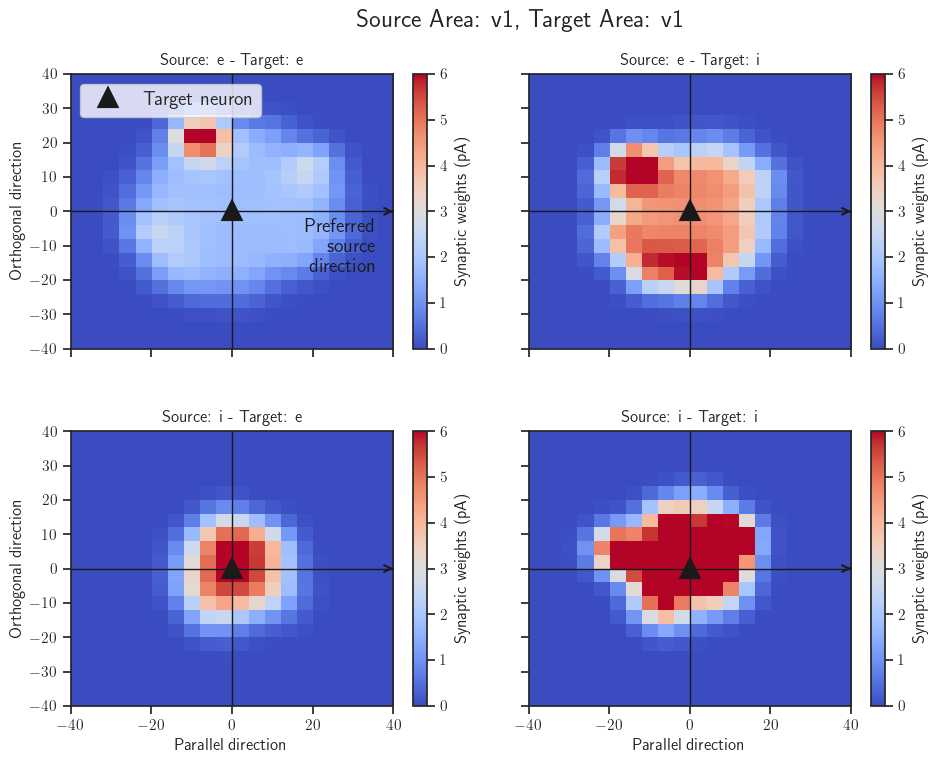

/home/jgalvan/.conda/envs/predictive_coding_tf212/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


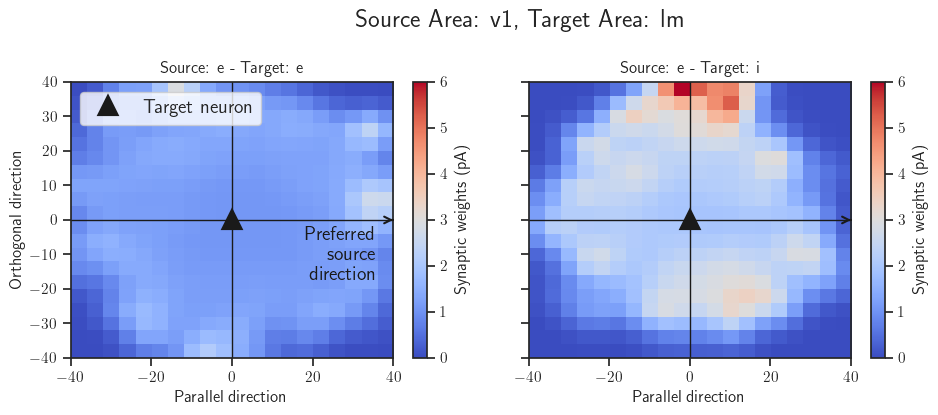

/home/jgalvan/.conda/envs/predictive_coding_tf212/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


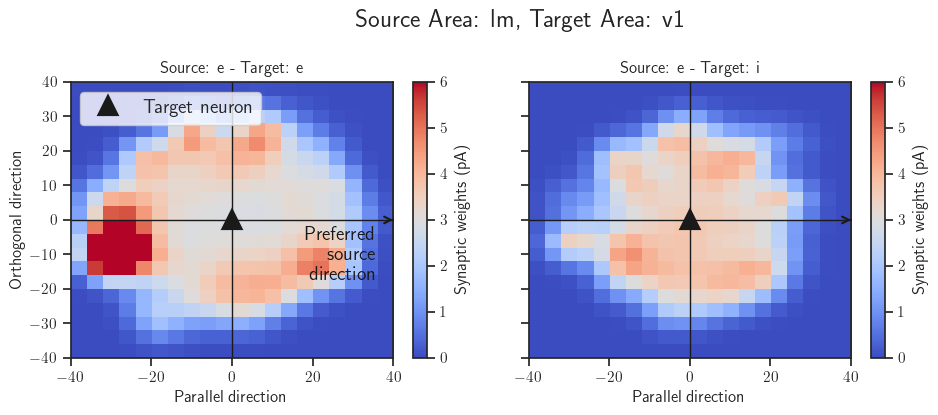

/home/jgalvan/.conda/envs/predictive_coding_tf212/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


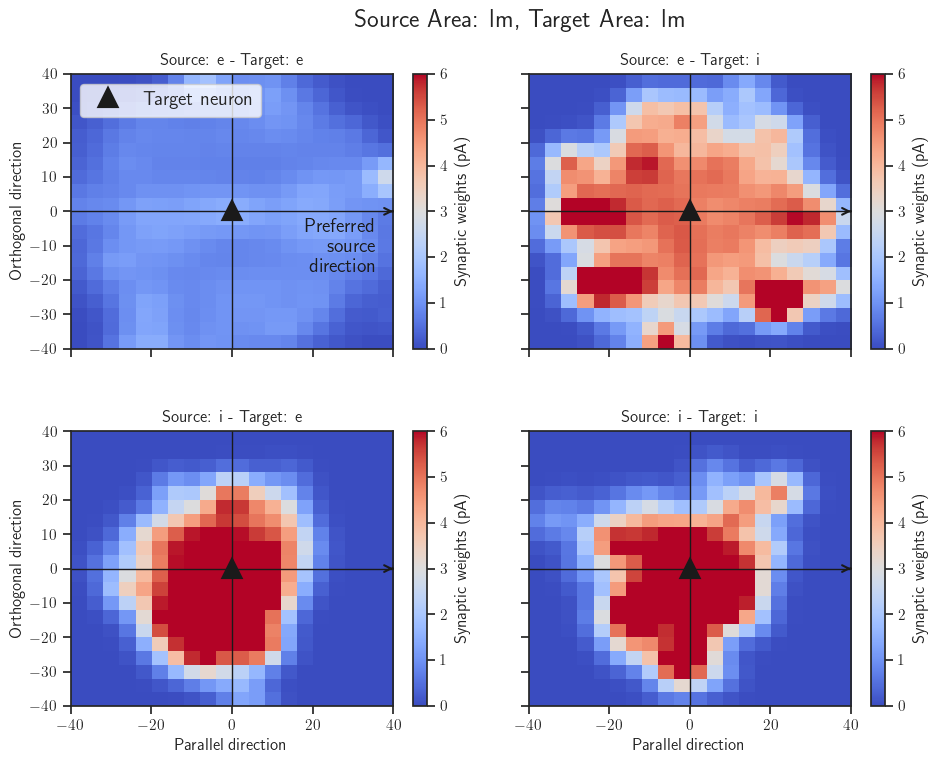

In [48]:
areas = ['v1', 'lm']
target_cell_types = ['e', 'i']
source_feature = 'DSI' # 'OSI'

for source_area in areas:
    source_df = df.loc[source_area]    
    for target_area in areas:
        target_df = df.loc[target_area]
        voltage_scale = (networks[target_area]['node_params']['V_th'] - networks[target_area]['node_params']['E_L']).astype(np.float32)
        if source_area == target_area:
            variable_key = f'{target_area}_sparse_recurrent_weights:0'
            indices = networks[target_area]["synapses"]["indices"].astype(np.int32)
            source_cell_types = ['e', 'i']
        else:
            variable_key = f'{target_area}_sparse_interarea_weights_{source_area}:0'
            indices = networks[target_area]['interarea_synapses'][source_area]["indices"].astype(np.int32)
            source_cell_types = ['e']
        # Calculate the voltage scale for node IDs
        node_type_ids = networks[target_area]['node_type_ids']

        fig = plt.figure(figsize=(6 * len(target_cell_types), 4 * len(source_cell_types)), constrained_layout=True)
        if len(source_cell_types) * len(target_cell_types) == 4:
            top_title_space = 0.9
        else:
            top_title_space = 0.8
        gs = gridspec.GridSpec(len(source_cell_types), len(target_cell_types) + 1, width_ratios=[1, 1, 0.035], 
                               wspace=0.2, hspace=0.3, top=top_title_space)
        # Define limits of the histograms
        global_min = 0
        global_max = 6

        plot_index = 0
        for row, source_cell_type in enumerate(source_cell_types):
            # Select source and target IDs
            source_tf_ids = source_df.index[(source_df['ei'] == source_cell_type) & (source_df['region'] == 'core') & (source_df[source_feature] > 0.2)].astype(np.int32).values
            for col, target_cell_type in enumerate(target_cell_types):
                target_tf_ids = target_df.index[(target_df['ei'] == target_cell_type) & (target_df['region'] == 'core') ].astype(np.int32).values
                # Create sets for fast lookup
                mask = fast_indices_masking(indices, target_tf_ids, source_tf_ids)
                selected_indices = indices[mask]
                target_indices = selected_indices[:, 0]
                source_indices = selected_indices[:, 1]
                # Mask voltage_scale_node_ids first
                voltage_scale_node_ids = voltage_scale[node_type_ids[target_indices]]
                initial_value_masked = np.abs(model_variables_dict['Initial'][variable_key][mask] * voltage_scale_node_ids)
                final_value_masked = np.abs(model_variables_dict['Restored'][variable_key][mask] * voltage_scale_node_ids)
                # Calculate tuning angle differences
                source_tuning_angles = source_df.loc[source_indices, 'preferred_angle'].values
                target_tuning_angles = target_df.loc[target_indices, 'preferred_angle'].values
                tuning_angle_diff = np.abs(source_tuning_angles - target_tuning_angles)
                tuning_angle_diff = np.minimum(tuning_angle_diff, 360 - tuning_angle_diff)
                # Calculate differences in coordinates
                source_azimuth = source_df.loc[source_indices, 'azimuth'].values
                target_azimuth = target_df.loc[target_indices, 'azimuth'].values
                source_elevation = source_df.loc[source_indices, 'elevation'].values
                target_elevation = target_df.loc[target_indices, 'elevation'].values
                diff_x = source_azimuth - target_azimuth
                diff_z = source_elevation - target_elevation
                # # rotate to the axis of target neuron tuning angle
                source_tuning_angle_rad = np.radians(source_tuning_angles)
                diff_x_rot = diff_x * np.cos(source_tuning_angle_rad + pi) + diff_z * np.sin(source_tuning_angle_rad + pi)
                diff_z_rot = diff_z * np.cos(source_tuning_angle_rad + pi) - diff_x * np.sin(source_tuning_angle_rad + pi)
                # target_tuning_angle_rad = np.radians(target_tuning_angles)
                # cos_angles = np.cos(target_tuning_angle_rad + pi)
                # sin_angles = np.sin(target_tuning_angle_rad + pi)
                # diff_x_rot = diff_z * sin_angles + diff_x * cos_angles
                # diff_z_rot = diff_z * cos_angles - diff_x * sin_angles

                bins = 20
                # area_dimensions = [[-80, 80], [-80, 80]]
                area_dimensions = [[-40, 40], [-40, 40]]
                # area_dimensions = [[-10, 10], [-10, 10]]

                hist, xedges_parallel, yedges_parallel = np.histogram2d(diff_z_rot, diff_x_rot, bins=bins, range=area_dimensions, weights=final_value_masked)
                count_hist, _, _ = np.histogram2d(diff_z_rot, diff_x_rot, range=area_dimensions, bins=bins)
                hist = np.divide(hist, count_hist, out=np.zeros_like(hist), where=count_hist != 0)
                # Apply Gaussian filter to histograms
                sigma = 1
                hist_filtered = gaussian_filter(hist, sigma=sigma)
                ax = plt.subplot(gs[row, col])
                im_filtered = ax.imshow(hist_filtered.T, origin='lower', 
                                                extent=[xedges_parallel[0], xedges_parallel[-1], yedges_parallel[0], yedges_parallel[-1]], 
                                                aspect='auto', cmap='coolwarm', vmin=global_min, vmax=global_max)
                ax.axhline(0, color='k', lw=1)
                ax.axvline(0, color='k', lw=1)
                ax.annotate('', xy=(ax.get_xlim()[1], 0), xytext=(ax.get_xlim()[1]-0.1, 0),
                            arrowprops=dict(arrowstyle='->', color='k', lw=1.5))
                cbar = plt.colorbar(im_filtered, ax=ax)
                cbar.set_label('Synaptic weights (pA)')
                if col == 0:
                    ax.set_ylabel('Orthogonal direction', fontsize=12)                        
                if col != 0:
                    plt.setp(ax.get_yticklabels(), visible=False)   
                if row == len(source_cell_types) - 1:
                    ax.set_xlabel('Parallel direction')
                else:
                    plt.setp(ax.get_xticklabels(), visible=False)

                ax.plot(0, 0, 'k^', markersize=12, markeredgewidth=3, label='Target neuron')
                if plot_index == 0:
                    # Position for the centered text at the right end of the x-axis
                    x_right = x_right = ax.get_xlim()[1] - 0.05 * (ax.get_xlim()[1] - ax.get_xlim()[0])  # Move left by 10% of x-axis range
                    y_position = -0.025 * (ax.get_ylim()[1] - ax.get_ylim()[0])
                    ax.text(x_right, y_position,
                            'Preferred \n source \n direction', color='k', ha='right', va='top', fontsize=14, weight='bold')
                    ax.legend(loc='upper left', fontsize = 14)

                ax.set_title(f'Source: {source_cell_type} - Target: {target_cell_type}')
                plot_index += 1

        fig.suptitle(f'Source Area: {source_area}, Target Area: {target_area}', fontsize=18)
        plt.show()

## SYNAPSES SCATTERING (CONNECTIONS AND WEIGHTS) IN AZIMUTH AND ELEVATION

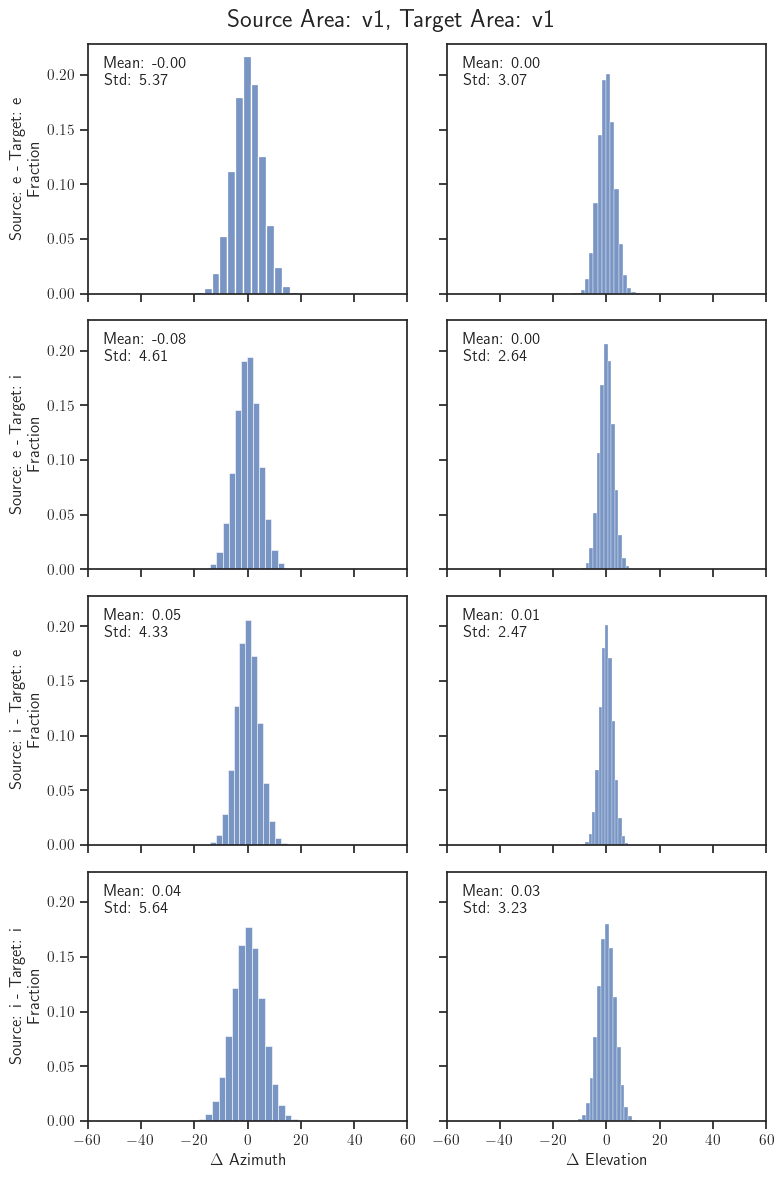

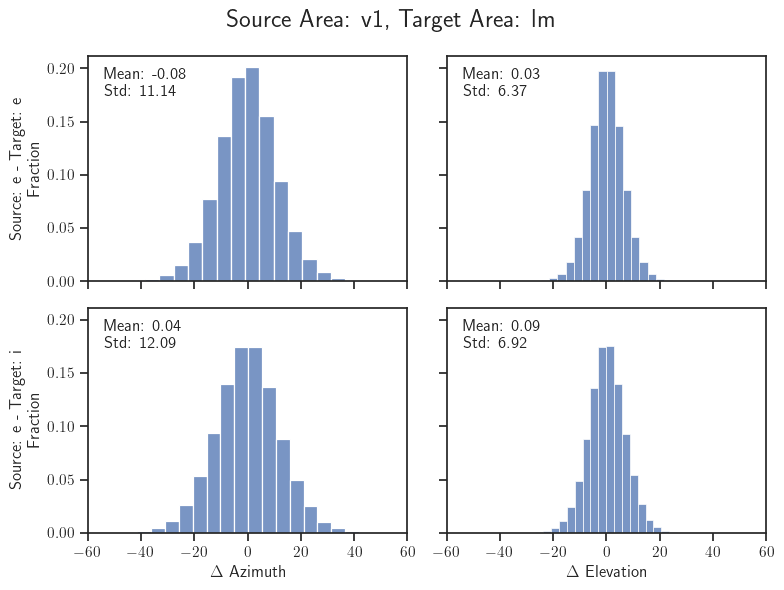

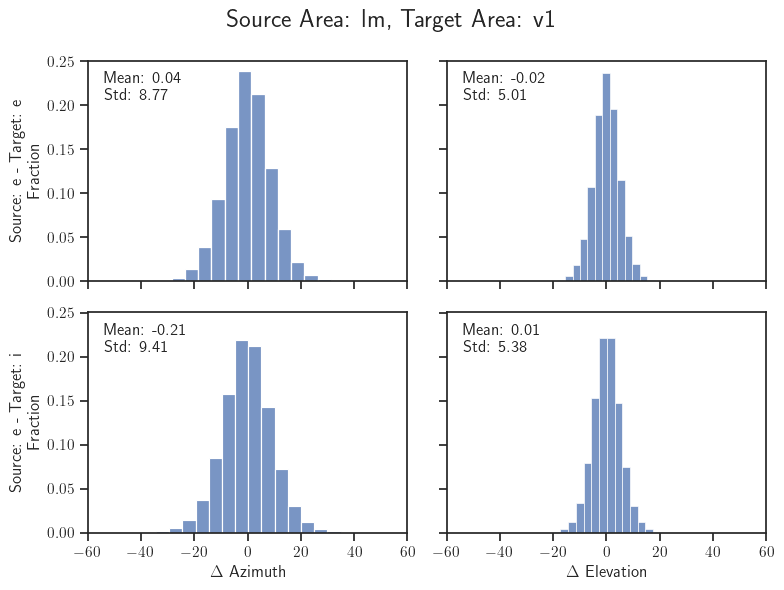

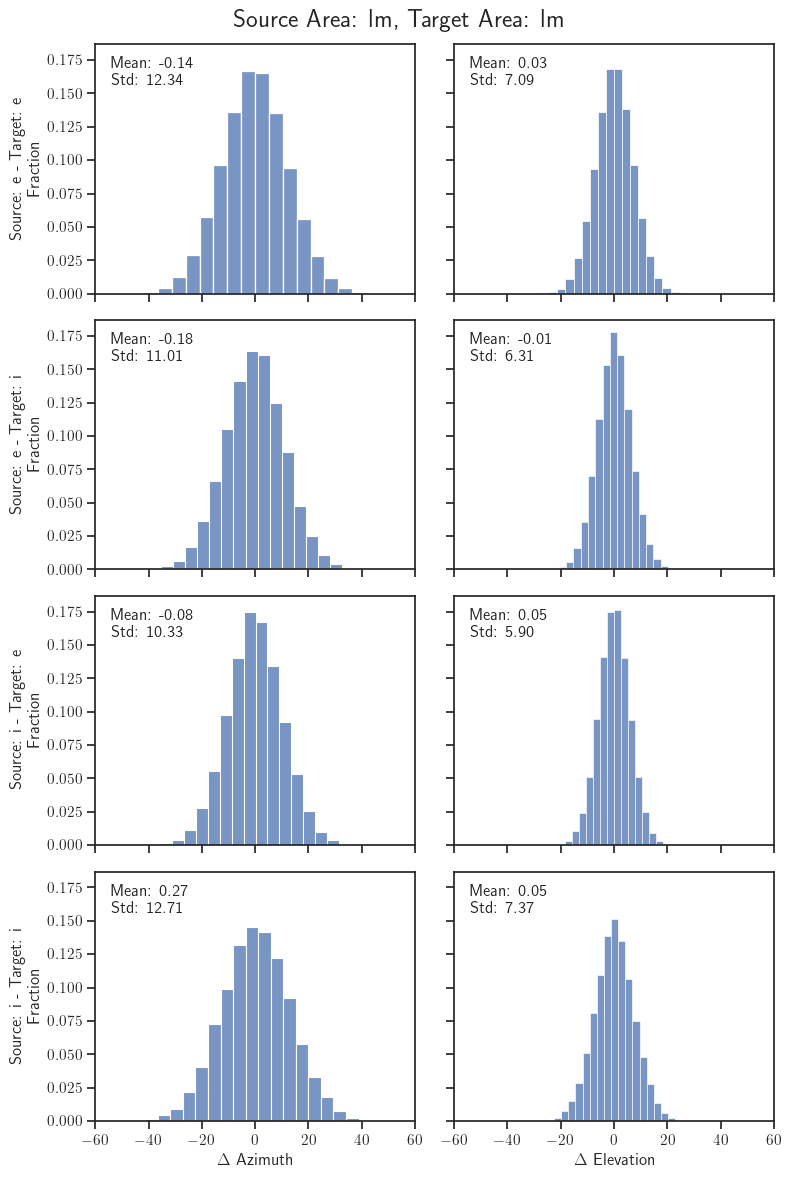

In [49]:
areas = ['v1', 'lm']
target_cell_types = ['e', 'i']

for source_area in areas:
    source_df = df.loc[source_area]    
    for target_area in areas:
        target_df = df.loc[target_area]
        if source_area == target_area:
            variable_key = f'{target_area}_sparse_recurrent_weights:0'
            indices = networks[target_area]["synapses"]["indices"].astype(np.int32)
            source_cell_types = ['e', 'i']
        else:
            variable_key = f'{target_area}_sparse_interarea_weights_{source_area}:0'
            indices = networks[target_area]['interarea_synapses'][source_area]["indices"].astype(np.int32)
            source_cell_types = ['e']
        # Calculate the voltage scale for node IDs
        node_type_ids = networks[target_area]['node_type_ids']

        fig, axs = plt.subplots(len(source_cell_types) * len(target_cell_types), 2, figsize=(8, 6*len(source_cell_types)), sharex=True, sharey=True)
        # axs = axs.flatten()
        plot_index = 0
        for row, source_cell_type in enumerate(source_cell_types):
            for col, target_cell_type in enumerate(target_cell_types):
                source_tf_ids = source_df.index[(source_df['ei'] == source_cell_type) & (source_df['region'] == 'core')].astype(np.int32).values
                target_tf_ids = target_df.index[(target_df['ei'] == target_cell_type) & (target_df['region'] == 'core')].astype(np.int32).values
                # Create sets for fast lookup
                mask = fast_indices_masking(indices, target_tf_ids, source_tf_ids)
                selected_indices = indices[mask]
                target_indices = selected_indices[:, 0]
                source_indices = selected_indices[:, 1]
                # Calculate differences in coordinates
                source_azimuth = source_df.loc[source_indices, 'azimuth'].values
                target_azimuth = target_df.loc[target_indices, 'azimuth'].values
                source_elevation = source_df.loc[source_indices, 'elevation'].values
                target_elevation = target_df.loc[target_indices, 'elevation'].values
                diff_x = source_azimuth - target_azimuth
                diff_z = source_elevation - target_elevation
                # Calculate statistics
                mean_diff_x = np.mean(diff_x)
                std_diff_x = np.std(diff_x)
                mean_diff_z = np.mean(diff_z)
                std_diff_z = np.std(diff_z)
                # Plot the distributions of diff x and diff z
                sns.histplot(diff_x, stat='proportion', bins=20, ax=axs[plot_index, 0])
                axs[plot_index, 0].set_xlim(-60, 60)
                axs[plot_index, 0].set_xlabel(r'$\Delta$ Azimuth')
                axs[plot_index, 0].set_ylabel(f'Source: {source_cell_type} - Target: {target_cell_type}\n Fraction')
                axs[plot_index, 0].text(0.05, 0.95, f'Mean: {mean_diff_x:.2f}\nStd: {std_diff_x:.2f}', transform=axs[plot_index, 0].transAxes, 
                                        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
                sns.histplot(diff_z, stat='proportion', bins=20, ax=axs[plot_index, 1])
                axs[plot_index, 1].set_xlim(-60, 60)
                axs[plot_index, 1].set_xlabel(r'$\Delta$ Elevation')
                axs[plot_index, 1].set_ylabel('Fraction')
                axs[plot_index, 1].text(0.05, 0.95, f'Mean: {mean_diff_z:.2f}\nStd: {std_diff_z:.2f}', transform=axs[plot_index, 1].transAxes, 
                                        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
                plot_index += 1

        fig.suptitle(f'Source Area: {source_area}, Target Area: {target_area}', fontsize=18)
        plt.tight_layout()

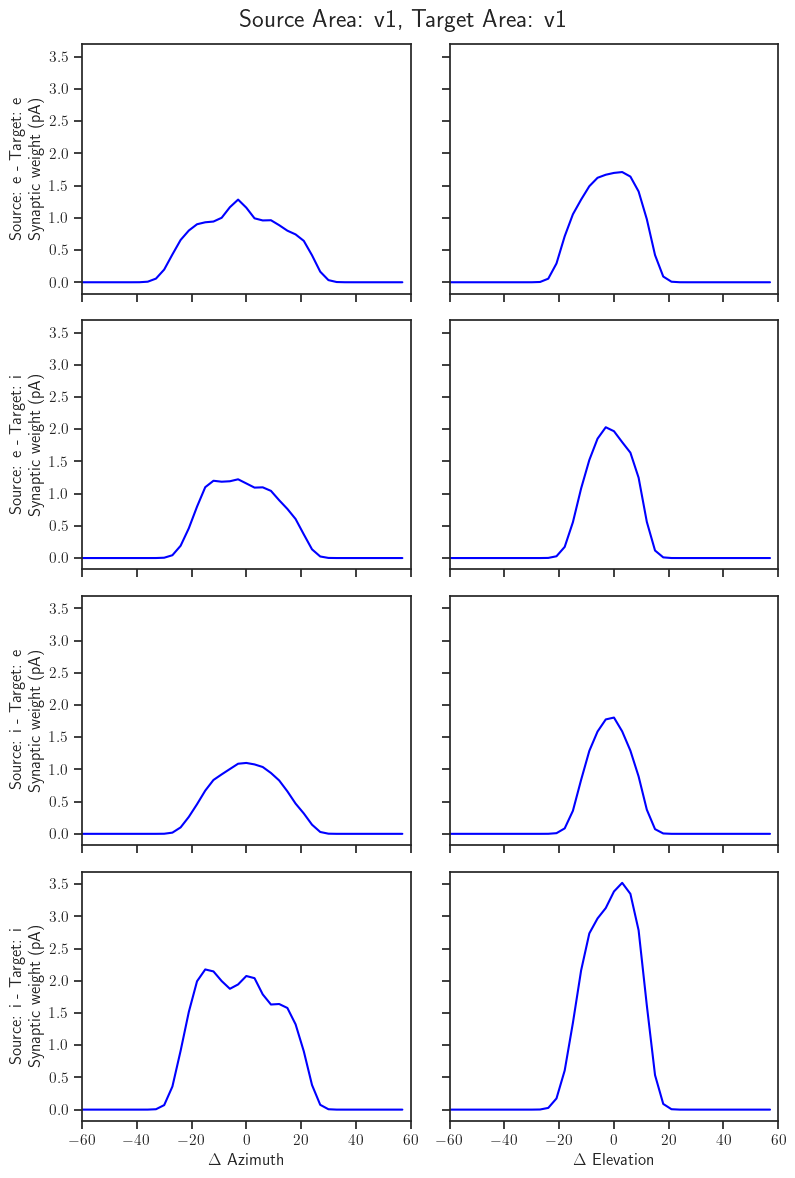

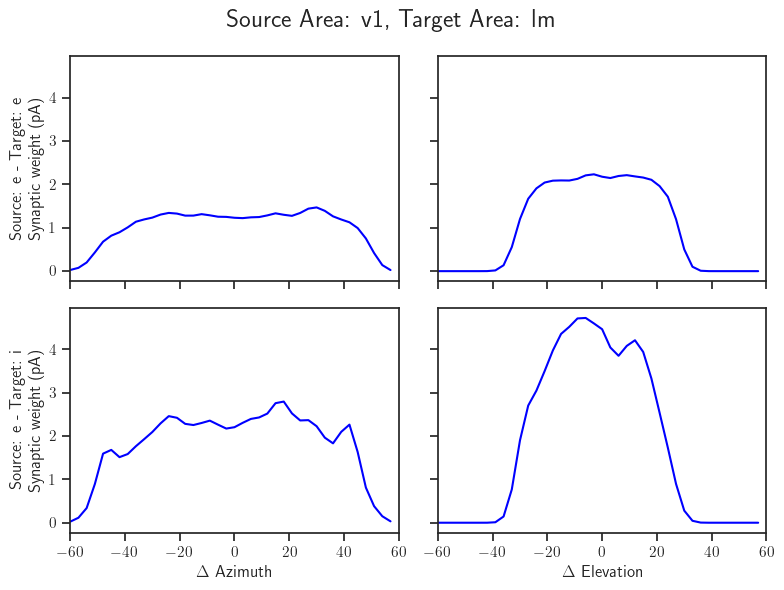

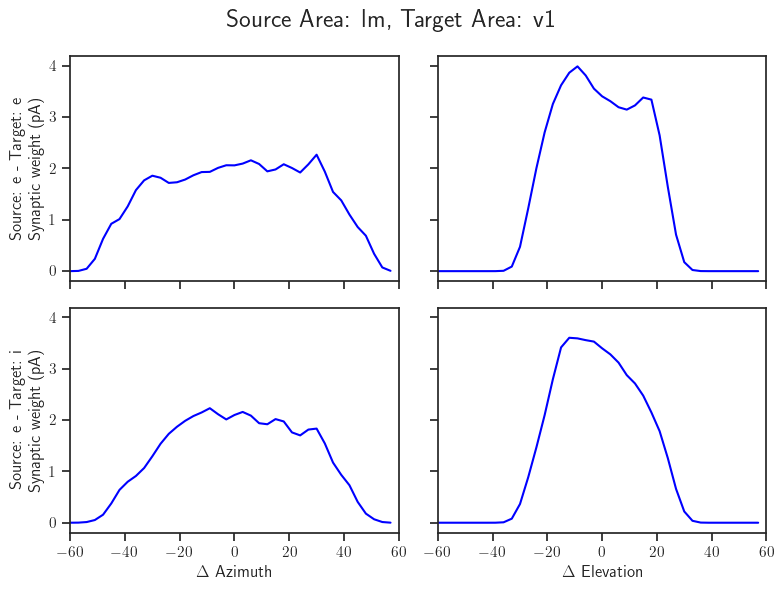

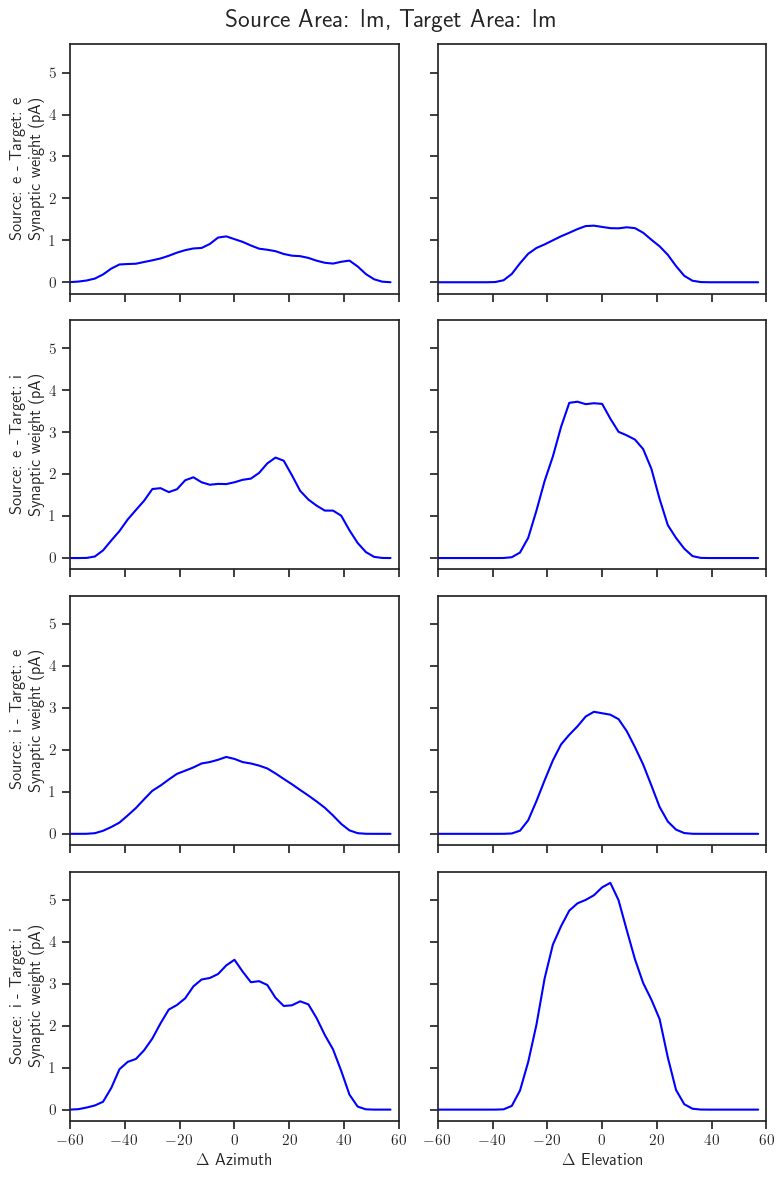

In [50]:
areas = ['v1', 'lm']
cell_types = ['e', 'i']

for source_area in areas:
    source_df = df.loc[source_area]    
    for target_area in areas:
        target_df = df.loc[target_area]
        voltage_scale = (networks[target_area]['node_params']['V_th'] - networks[target_area]['node_params']['E_L']).astype(np.float32)
        if source_area == target_area:
            variable_key = f'{target_area}_sparse_recurrent_weights:0'
            indices = networks[target_area]["synapses"]["indices"].astype(np.int32)
            source_cell_types = ['e', 'i']
        else:
            variable_key = f'{target_area}_sparse_interarea_weights_{source_area}:0'
            indices = networks[target_area]['interarea_synapses'][source_area]["indices"].astype(np.int32)
            source_cell_types = ['e']
        # Calculate the voltage scale for node IDs
        node_type_ids = networks[target_area]['node_type_ids']

        fig, axs = plt.subplots(len(source_cell_types) * len(cell_types), 2, figsize=(8, 6*len(source_cell_types)), sharex=True, sharey=True)
        plot_index = 0
        for row, source_cell_type in enumerate(source_cell_types):
            source_tf_ids = source_df.index[(source_df['ei'] == source_cell_type) & (source_df['region'] == 'core')].astype(np.int32).values
            for col, target_cell_type in enumerate(cell_types):
                target_tf_ids = target_df.index[(target_df['ei'] == target_cell_type) & (target_df['region'] == 'core') ].astype(np.int32).values
                # Create sets for fast lookup
                mask = fast_indices_masking(indices, target_tf_ids, source_tf_ids)
                selected_indices = indices[mask]
                target_indices = selected_indices[:, 0]
                source_indices = selected_indices[:, 1]
                # Mask voltage_scale_node_ids first
                voltage_scale_node_ids = voltage_scale[node_type_ids[target_indices]]
                initial_value_masked = np.abs(model_variables_dict['Initial'][variable_key][mask] * voltage_scale_node_ids)
                final_value_masked = np.abs(model_variables_dict['Restored'][variable_key][mask] * voltage_scale_node_ids)
                # # Calculate tuning angle differences
                # source_tuning_angles = source_df.loc[source_indices, 'preferred_angle'].values
                # target_tuning_angles = target_df.loc[target_indices, 'preferred_angle'].values
                # tuning_angle_diff = np.abs(source_tuning_angles - target_tuning_angles)
                # tuning_angle_diff = np.minimum(tuning_angle_diff, 360 - tuning_angle_diff)
                # Calculate differences in coordinates
                source_azimuth = source_df.loc[source_indices, 'azimuth'].values
                target_azimuth = target_df.loc[target_indices, 'azimuth'].values
                source_elevation = source_df.loc[source_indices, 'elevation'].values
                target_elevation = target_df.loc[target_indices, 'elevation'].values
                diff_x = source_azimuth - target_azimuth
                diff_z = source_elevation - target_elevation
                # target_tuning_angle_rad = np.radians(target_tuning_angles[selected_indices[:, 0]])
                # diff_x_rot = diff_x * np.cos(target_tuning_angle_rad+np.pi) + diff_z * np.sin(target_tuning_angle_rad+np.pi)
                # diff_z_rot = diff_z * np.cos(target_tuning_angle_rad+np.pi) - diff_x * np.sin(target_tuning_angle_rad+np.pi)
                bins = 40  
                area_dimensions = [[-60, 60], [-60, 60]]
                hist, xedges_final, yedges_final = np.histogram2d(diff_z, diff_x, bins=bins, range=area_dimensions, weights=final_value_masked)
                count_hist, _, _ = np.histogram2d(diff_z, diff_x, range=area_dimensions, bins=bins)
                hist = np.divide(hist, count_hist, out=np.zeros_like(hist), where=count_hist != 0)
                # Apply Gaussian filter to histograms
                sigma = 1  
                hist_filtered = gaussian_filter(hist, sigma=sigma)
                # Calculate Marginal Distributions
                marginal_final_x = np.mean(hist_filtered, axis=0)
                marginal_final_z = np.mean(hist_filtered, axis=1)
                # Plot the distribution of marginal_final_x and marginal_final_z 
                axs[plot_index, 0].plot(xedges_final[:-1], marginal_final_x, color='blue')
                axs[plot_index, 0].set_xlim(-60, 60)
                axs[plot_index, 0].set_ylabel(f'Source: {source_cell_type} - Target: {target_cell_type}\n Synaptic weight (pA)')
                axs[plot_index, 1].plot(yedges_final[:-1], marginal_final_z, color='blue')
                axs[plot_index, 1].set_xlim(-60, 60)
                plot_index += 1

        axs[plot_index-1, 0].set_xlabel(r'$\Delta$ Azimuth')
        axs[plot_index-1, 1].set_xlabel(r'$\Delta$ Elevation')
        fig.suptitle(f'Source Area: {source_area}, Target Area: {target_area}', fontsize=18)
        plt.tight_layout()
        plt.show()

## OSI/DSI ANALYSIS AND LIKE-LIKE RULES

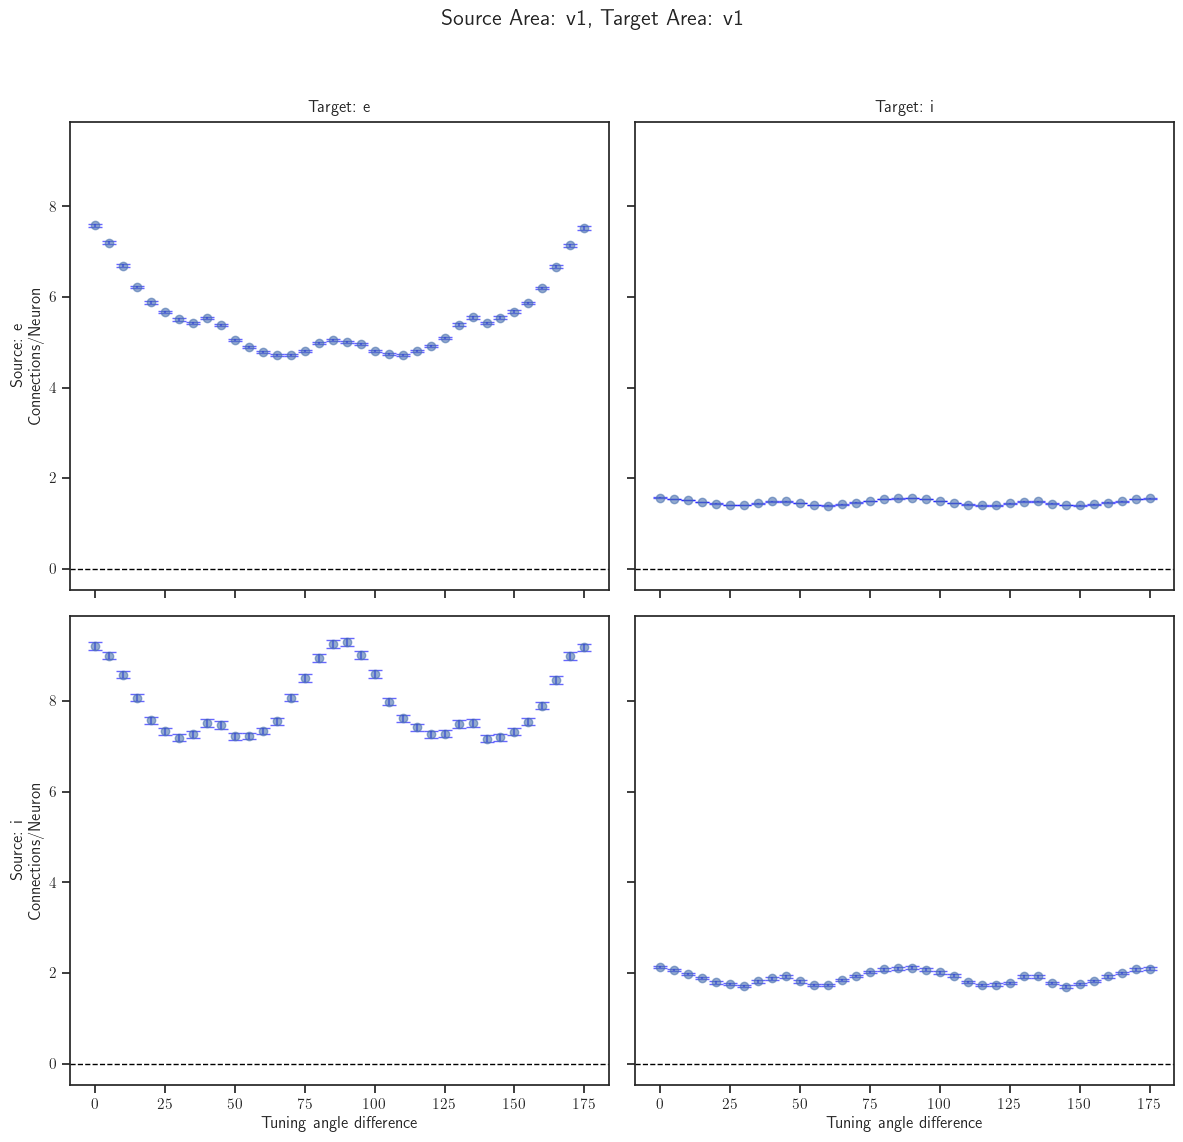

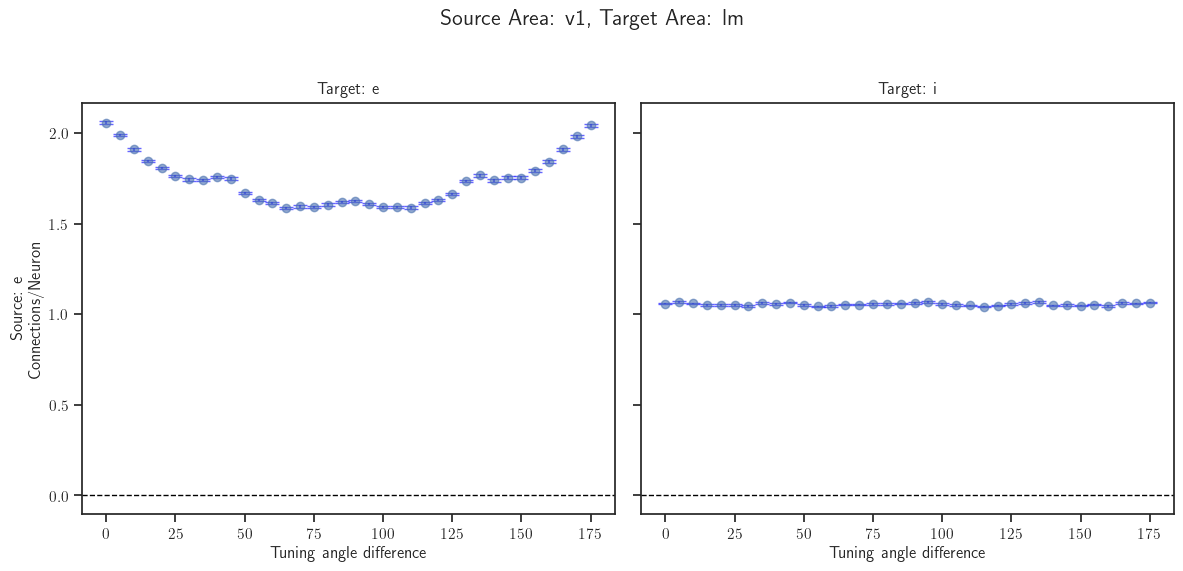

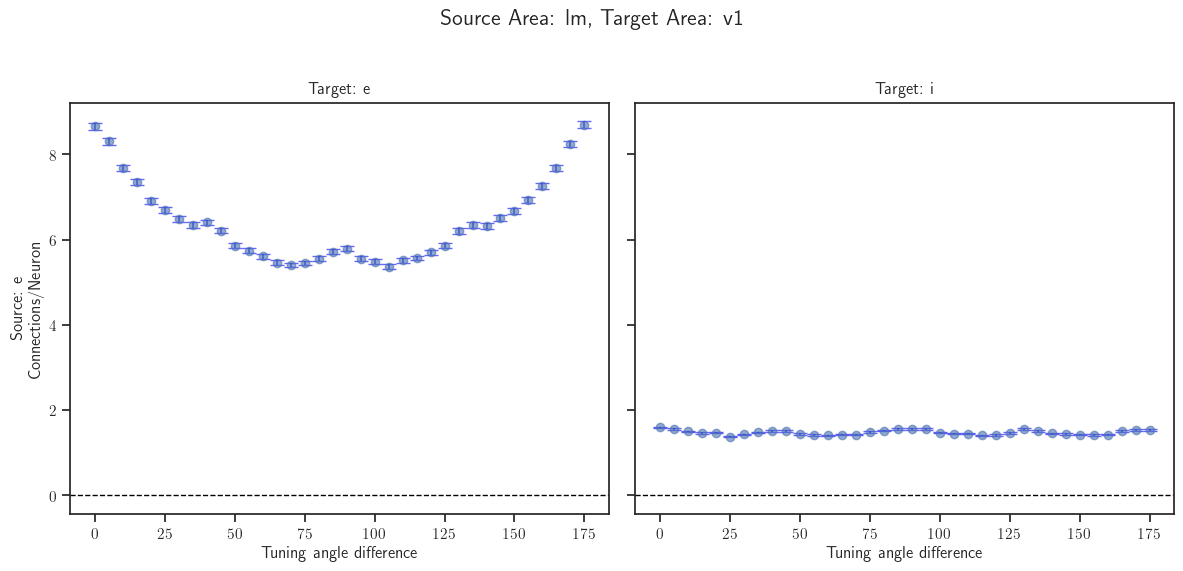

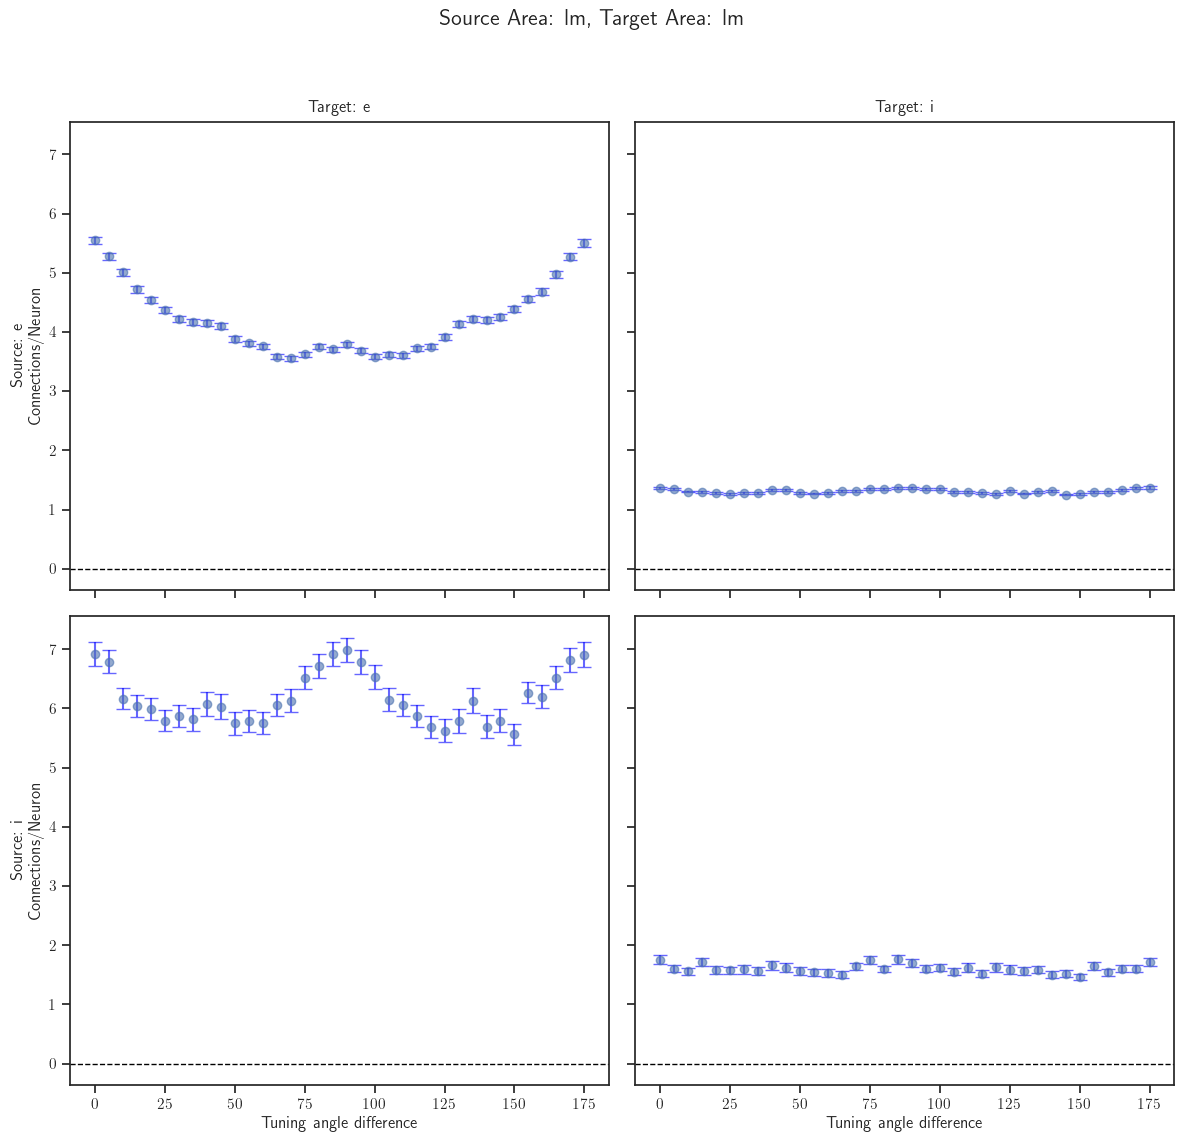

In [51]:
# %%timeit
areas = ['v1', 'lm']
cell_types = ['e', 'i']

for source_area in areas:
    source_df = df.loc[source_area]    
    for target_area in areas:
        target_df = df.loc[target_area]
        if source_area == target_area:
            variable_key = f'{target_area}_sparse_recurrent_weights:0'
            indices = networks[target_area]["synapses"]["indices"].astype(np.int32)
            source_cell_types = ['e', 'i']
        else:
            variable_key = f'{target_area}_sparse_interarea_weights_{source_area}:0'
            indices = networks[target_area]['interarea_synapses'][source_area]["indices"].astype(np.int32)
            source_cell_types = ['e']

        fig, axs = plt.subplots(len(source_cell_types), len(cell_types), figsize=(12, 6*len(source_cell_types)), sharex=True, sharey=True)
        axs = axs.flatten()
        plot_index = 0
        for row, source_cell_type in enumerate(source_cell_types):
            source_tf_ids = source_df.index[(source_df['ei'] == source_cell_type)].astype(np.int32).values
            for col, target_cell_type in enumerate(cell_types):
                target_tf_ids = target_df.index[(target_df['ei'] == target_cell_type) & (target_df['region'] == 'core') ].astype(np.int32).values
                # Create sets for fast lookup
                mask = fast_indices_masking(indices, target_tf_ids, source_tf_ids)
                selected_indices = indices[mask]
                target_indices = selected_indices[:, 0]
                source_indices = selected_indices[:, 1]
                # Calculate tuning angle differences
                source_tuning_angles = source_df.loc[source_indices, 'preferred_angle'].values
                target_tuning_angles = target_df.loc[target_indices, 'preferred_angle'].values
                tuning_angle_diff = np.abs(source_tuning_angles - target_tuning_angles)
                tuning_angle_diff = np.minimum(tuning_angle_diff, 360 - tuning_angle_diff)

                bins = np.arange(0, 181, 5)
                bin_counts = np.zeros(len(bins) - 1)
                bin_errors = np.zeros(len(bins) - 1)
                bin_indices = np.digitize(tuning_angle_diff, bins) - 1
                # Loop over the bins to calculate mean connections per neuron and their errors
                for i in range(len(bins) - 1):
                    # Get the connections that fall into the current bin
                    connections_in_bin = selected_indices[bin_indices == i]
                    
                    if connections_in_bin.size > 0:
                        # Unique source neurons and counts in the current bin
                        unique_source_neurons, neuron_indices, counts = np.unique(connections_in_bin[:, 1], 
                                                                                return_inverse=True, return_counts=True)
                        num_neurons_in_bin = unique_source_neurons.size
                        
                        if num_neurons_in_bin > 0:
                            # Calculate mean and error for the bin using NumPy operations
                            bin_counts[i] = np.mean(counts)
                            # Calculate the standard deviation and SEM for the bin
                            std_dev = np.std(counts, ddof=1)  # ddof=1 for sample standard deviation
                            bin_errors[i] = std_dev / np.sqrt(num_neurons_in_bin)
            
                # Plot the histogram
                axs[plot_index].errorbar(bins[:-1], bin_counts, yerr=bin_errors, fmt='o', ecolor='blue', capsize=5, label='Connections/Neuron', alpha=0.6)
                axs[plot_index].axhline(y=0, color='black', linestyle='--', linewidth=1)

                if row == 0:
                    axs[plot_index].set_title(f'Target: {target_cell_type}', fontsize=12)
                if col == 0:
                    axs[plot_index].set_ylabel(f'Source: {source_cell_type}\nConnections/Neuron', fontsize=12)
                if row == len(source_cell_types) - 1:
                    axs[plot_index].set_xlabel(f'Tuning angle difference', fontsize=12)

                # axs[plot_index].grid(True)
                plot_index += 1

        fig.suptitle(f'Source Area: {source_area}, Target Area: {target_area}', fontsize=16)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

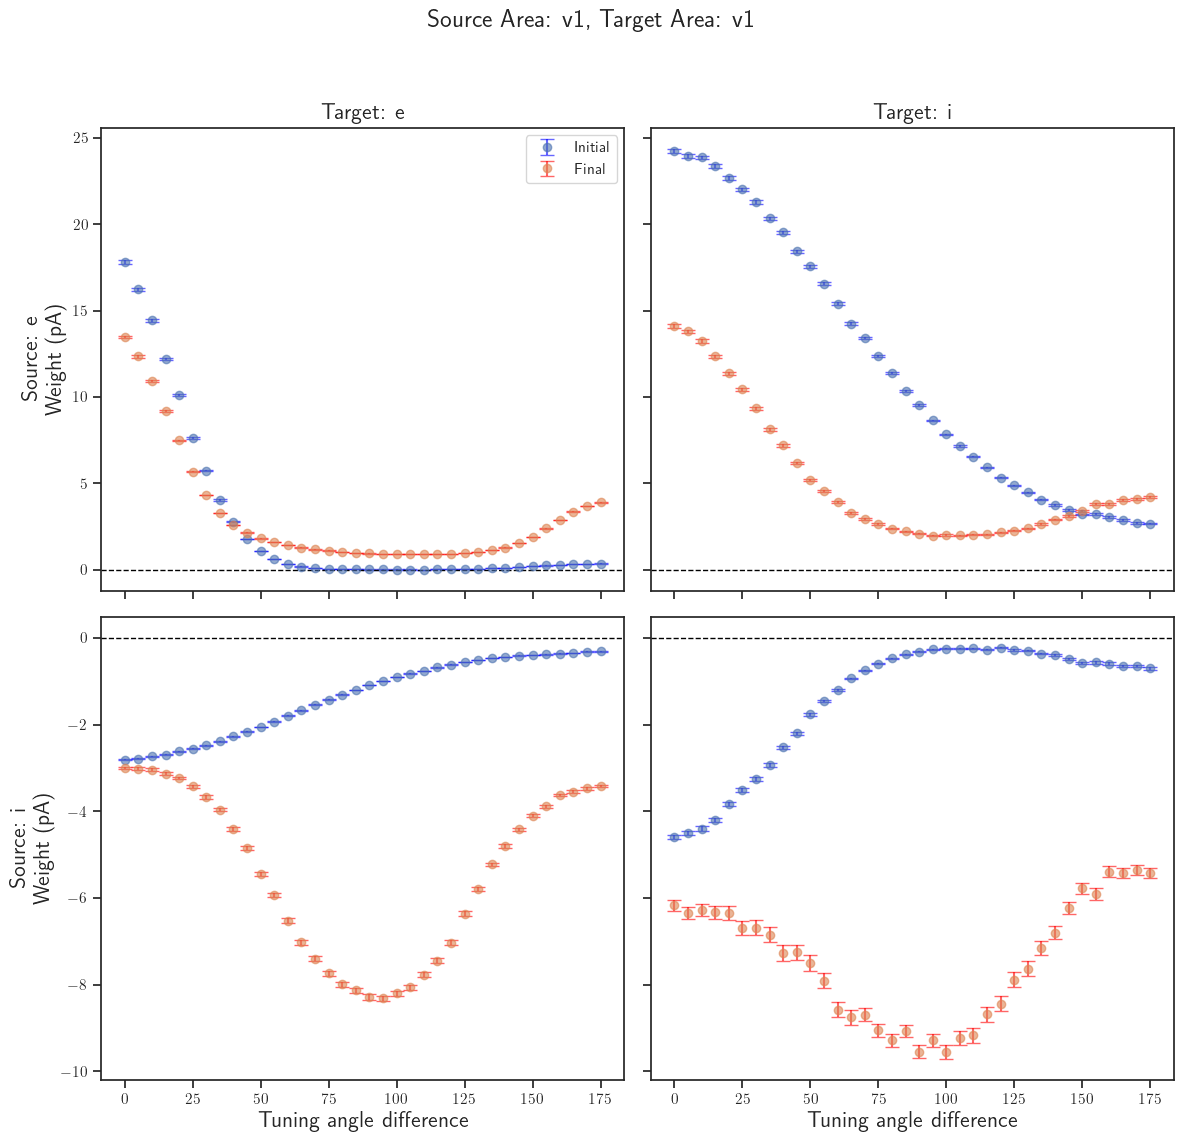

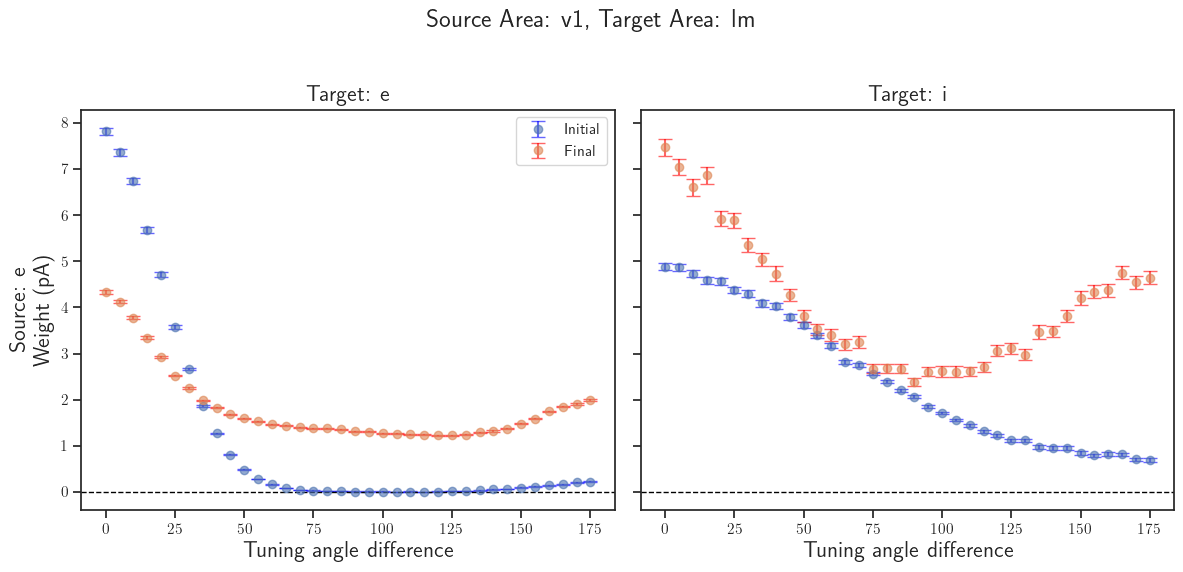

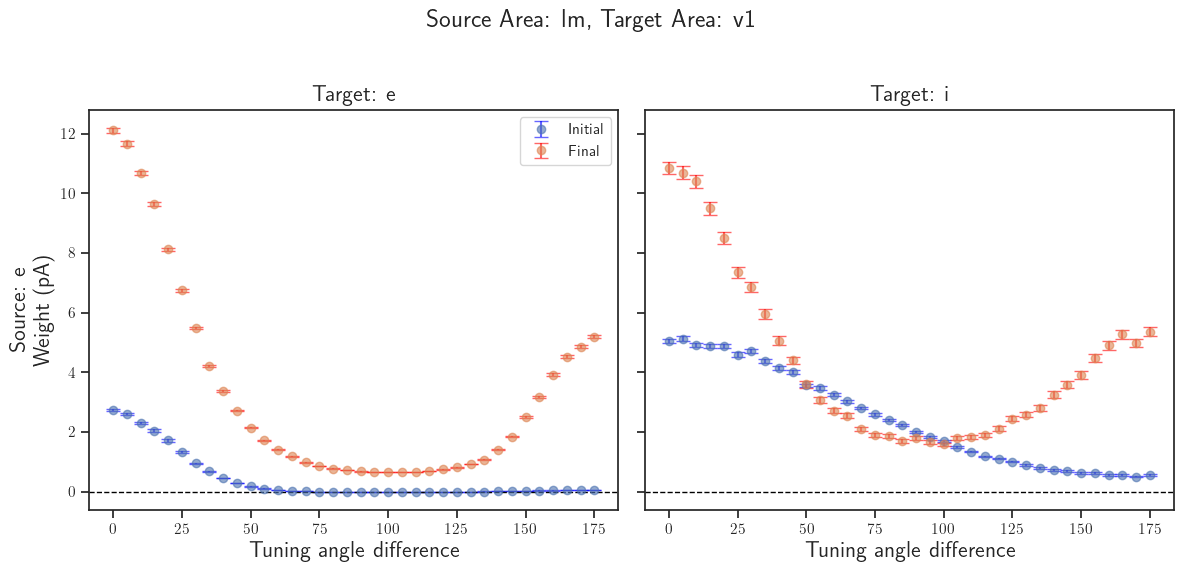

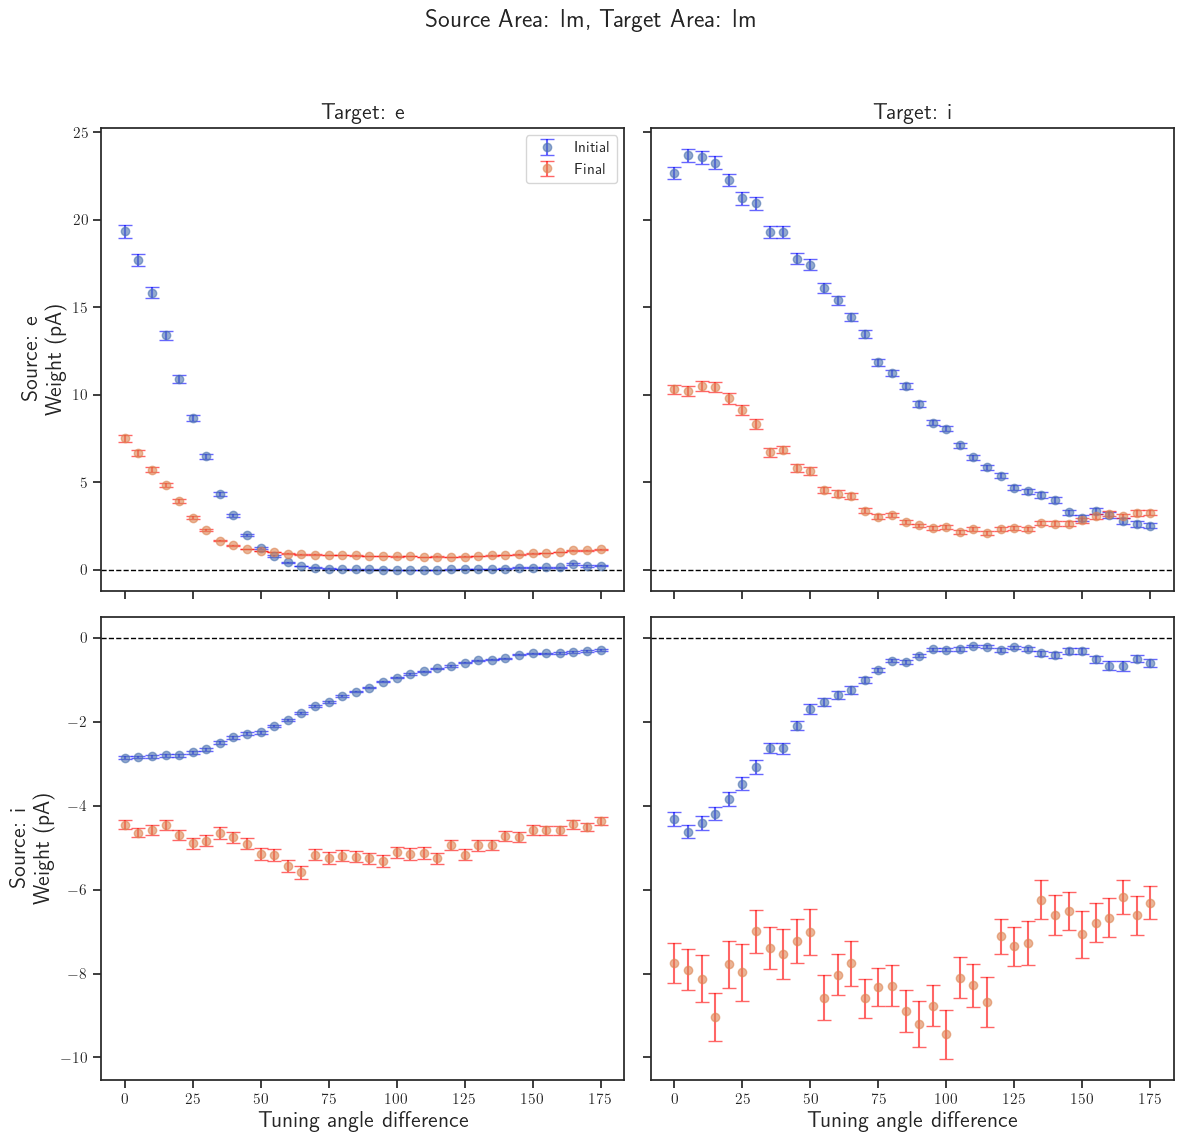

In [52]:
areas = ['v1', 'lm']
target_cell_types = ['e', 'i']

for source_area in areas:
    source_df = df.loc[source_area] 
    for target_area in areas:
        target_df = df.loc[target_area]
        voltage_scale = (networks[target_area]['node_params']['V_th'] - networks[target_area]['node_params']['E_L']).astype(np.float32)
        if source_area == target_area:
            variable_key = f'{target_area}_sparse_recurrent_weights:0'
            indices = networks[target_area]["synapses"]["indices"].astype(np.int32)
            source_cell_types = ['e', 'i']
        else:
            variable_key = f'{target_area}_sparse_interarea_weights_{source_area}:0'
            indices = networks[target_area]['interarea_synapses'][source_area]["indices"].astype(np.int32)
            source_cell_types = ['e']
        # Calculate the voltage scale for node IDs
        node_type_ids = networks[target_area]['node_type_ids']

        fig, axs = plt.subplots(len(source_cell_types), len(target_cell_types), figsize=(12, 6*len(source_cell_types)), sharex=True, sharey='row')
        axs = axs.flatten()
        plot_index = 0
        for row, source_cell_type in enumerate(source_cell_types):
            source_tf_ids = source_df.index[(source_df['ei'] == source_cell_type) & (source_df['region'] == 'core')].astype(np.int32).values
            for col, target_cell_type in enumerate(target_cell_types):
                target_tf_ids = target_df.index[(target_df['ei'] == target_cell_type) & (target_df['region'] == 'core') ].astype(np.int32).values
                # Create sets for fast lookup
                mask = fast_indices_masking(indices, target_tf_ids, source_tf_ids)
                selected_indices = indices[mask]
                target_indices = selected_indices[:, 0]
                source_indices = selected_indices[:, 1]
                # Mask voltage_scale_node_ids first
                voltage_scale_node_ids = voltage_scale[node_type_ids[target_indices]]
                initial_value_masked = model_variables_dict['Initial'][variable_key][mask] * voltage_scale_node_ids
                final_value_masked = model_variables_dict['Restored'][variable_key][mask] * voltage_scale_node_ids
                # Calculate tuning angle differences
                source_tuning_angles = source_df.loc[source_indices, 'preferred_angle'].values
                target_tuning_angles = target_df.loc[target_indices, 'preferred_angle'].values
                tuning_angle_diff = np.abs(source_tuning_angles - target_tuning_angles)
                tuning_angle_diff = np.minimum(tuning_angle_diff, 360 - tuning_angle_diff)

                bins = np.arange(0, 181, 5)
                bin_indices = np.digitize(tuning_angle_diff, bins)
                bin_initial_values = np.zeros(len(bins)-1)
                bin_initial_errors = np.zeros(len(bins)-1)
                bin_final_values = np.zeros(len(bins)-1)
                bin_final_errors = np.zeros(len(bins)-1)
                for i in range(1, len(bins)):
                    initial_values_in_bin = initial_value_masked[bin_indices == i]
                    if initial_values_in_bin.size > 0:
                        bin_initial_values[i-1] = np.mean(initial_values_in_bin)
                        std_dev_initial = np.std(initial_values_in_bin, ddof=1)
                        bin_initial_errors[i-1] = std_dev_initial / np.sqrt(initial_values_in_bin.size)

                    final_values_in_bin = final_value_masked[bin_indices == i]
                    if final_values_in_bin.size > 0:
                        bin_final_values[i-1] = np.mean(final_values_in_bin)
                        std_dev_final = np.std(final_values_in_bin, ddof=1)
                        bin_final_errors[i-1] = std_dev_final / np.sqrt(final_values_in_bin.size)

                axs[plot_index].errorbar(bins[:-1], bin_initial_values, yerr=bin_initial_errors, fmt='o', ecolor='blue', capsize=5, label='Initial', alpha=0.6)
                axs[plot_index].errorbar(bins[:-1], bin_final_values, yerr=bin_final_errors, fmt='o', ecolor='red', capsize=5, label='Final', alpha=0.6)
                axs[plot_index].axhline(y=0, color='black', linestyle='--', linewidth=1)

                if row == 0:
                    axs[plot_index].set_title(f'Target: {target_cell_type}', fontsize=16)
                if col == 0:
                    axs[plot_index].set_ylabel(f'Source: {source_cell_type}\nWeight (pA)', fontsize=16)
                if row == len(source_cell_types) - 1:
                    axs[plot_index].set_xlabel(r'Tuning angle difference', fontsize=16)
                if row == 0 and col == 0:
                    axs[plot_index].legend()

                plot_index += 1

        fig.suptitle(f'Source Area: {source_area}, Target Area: {target_area}', fontsize=18)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()


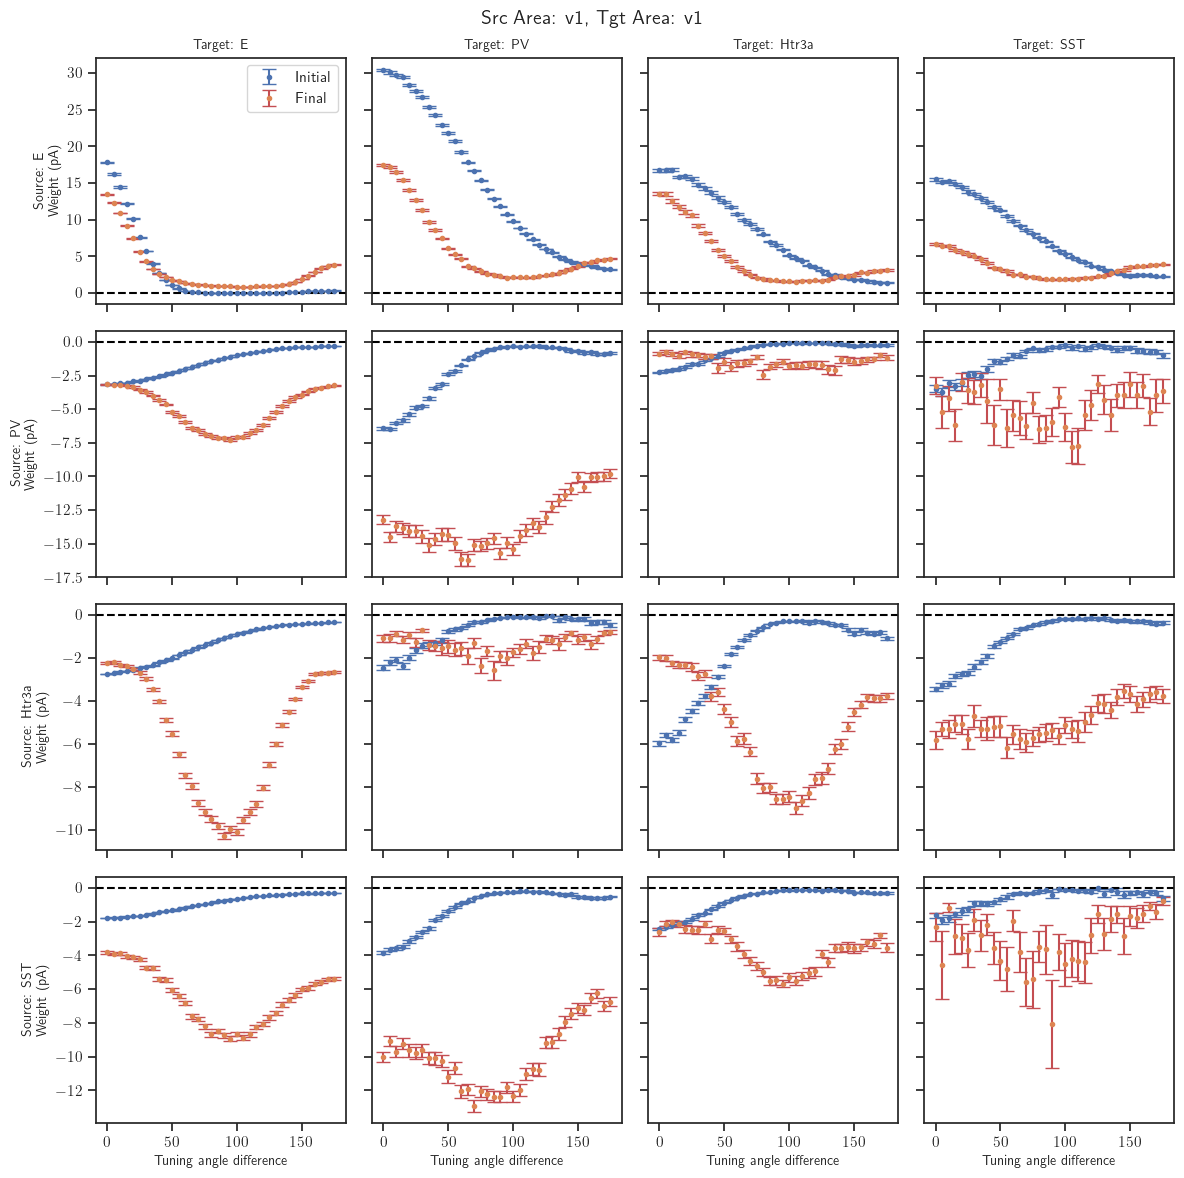

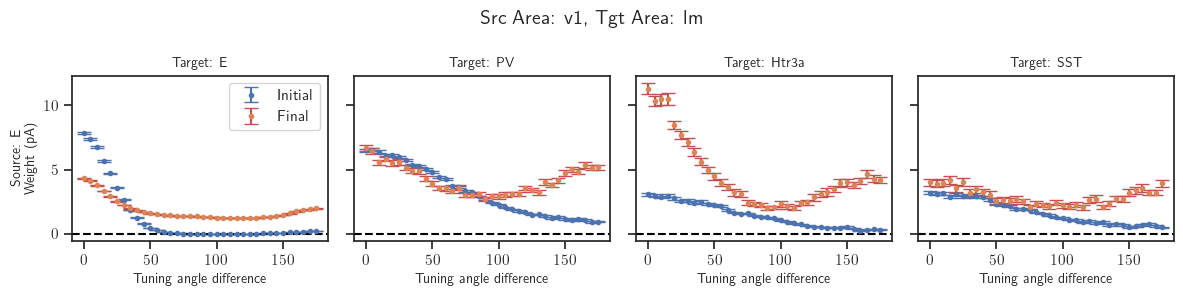

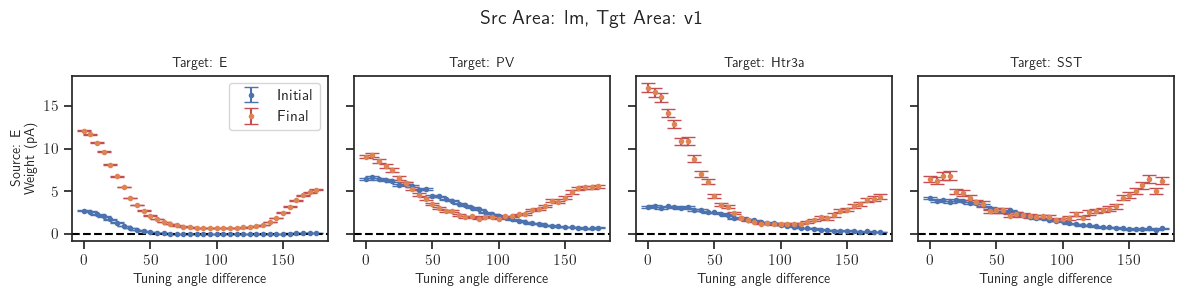

/home/jgalvan/.conda/envs/predictive_coding_tf212/lib/python3.11/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/jgalvan/.conda/envs/predictive_coding_tf212/lib/python3.11/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


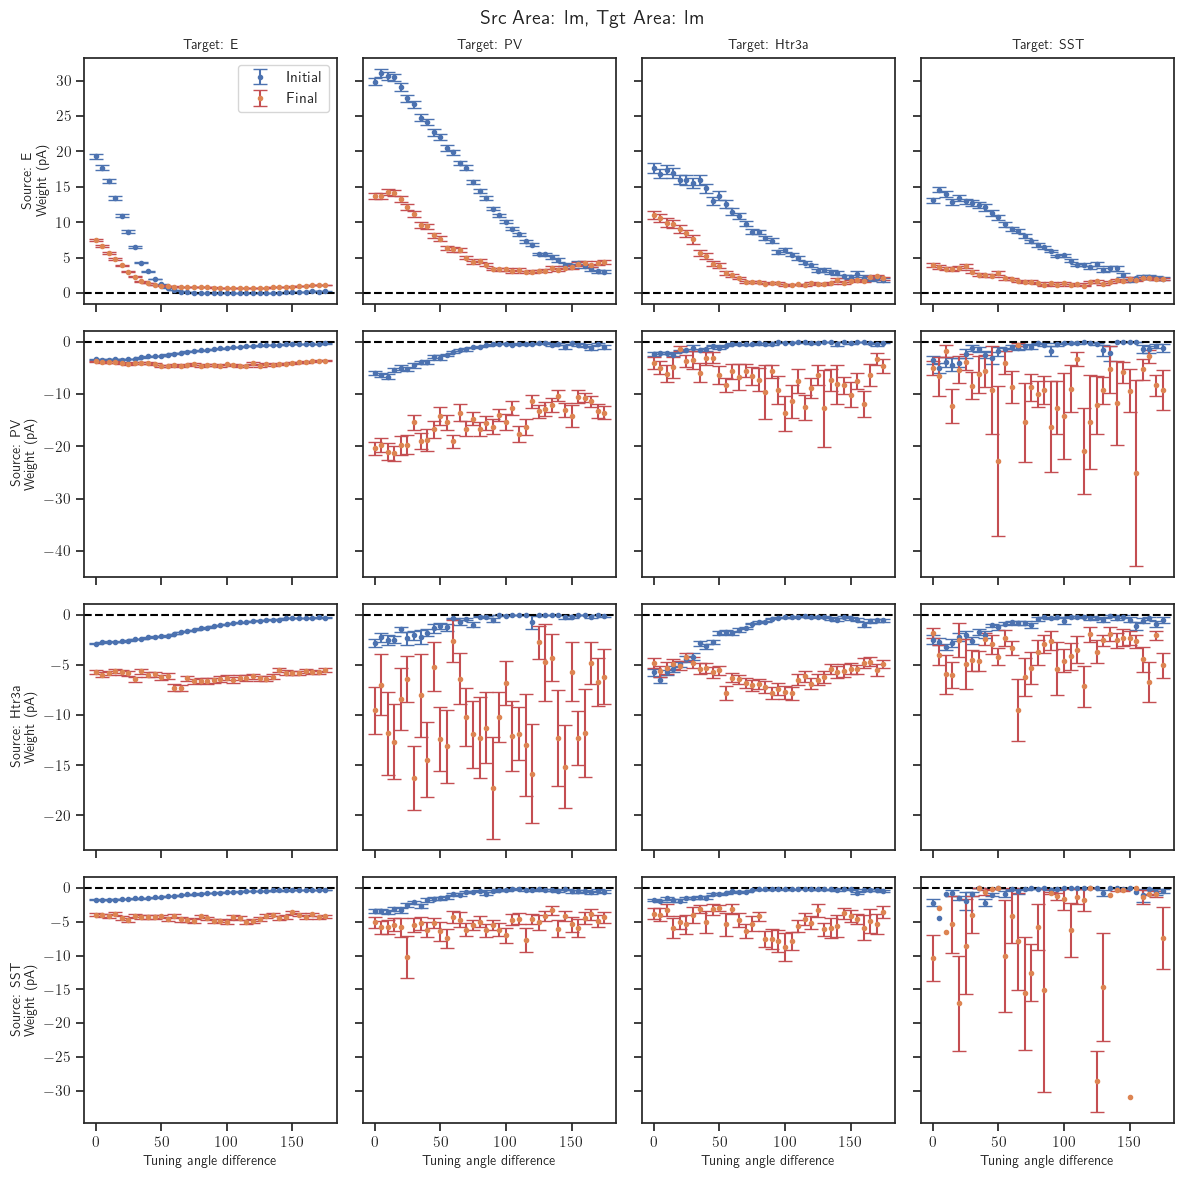

In [53]:
areas = ['v1', 'lm']
target_cell_types = ['E', 'PV', 'Htr3a', 'SST'] #['L2/3 Exc', 'L4 Exc', 'L5 Exc', 'L6 Exc']
source_cell_types = ['E', 'PV', 'Htr3a', 'SST']
num_subplots = len(source_cell_types)

for source_area in areas:
    source_df = df.loc[source_area] 
    for target_area in areas:
        target_df = df.loc[target_area]
        voltage_scale = (networks[target_area]['node_params']['V_th'] - networks[target_area]['node_params']['E_L']).astype(np.float32)
        if source_area == target_area:
            variable_key = f'{target_area}_sparse_recurrent_weights:0'
            indices = networks[target_area]["synapses"]["indices"].astype(np.int32)
            source_cell_types = ['E', 'PV', 'Htr3a', 'SST']   
        else:
            variable_key = f'{target_area}_sparse_interarea_weights_{source_area}:0'
            indices = networks[target_area]['interarea_synapses'][source_area]["indices"].astype(np.int32)
            source_cell_types = ['E']
        # Calculate the voltage scale for node IDs
        node_type_ids = networks[target_area]['node_type_ids']

        fig, axs = plt.subplots(len(source_cell_types), 4, figsize=(12, 3*len(source_cell_types)), sharex=True, sharey='row')
        axs = axs.flatten()
        plot_index = 0
        for row, source_cell_type in enumerate(source_cell_types):
            source_tf_ids = source_df.index[(source_df['cell_type'].str.contains(source_cell_type)) & (source_df['region'] == 'core')].astype(np.int32).values
            for col, target_cell_type in enumerate(target_cell_types):
                target_tf_ids = target_df.index[(target_df['cell_type'].str.contains(target_cell_type)) & (target_df['region'] == 'core')].astype(np.int32).values
                # Create sets for fast lookup
                mask = fast_indices_masking(indices, target_tf_ids, source_tf_ids)
                selected_indices = indices[mask]
                target_indices = selected_indices[:, 0]
                source_indices = selected_indices[:, 1]
                # Mask voltage_scale_node_ids first
                voltage_scale_node_ids = voltage_scale[node_type_ids[target_indices]]
                initial_value_masked = model_variables_dict['Initial'][variable_key][mask] * voltage_scale_node_ids
                final_value_masked = model_variables_dict['Restored'][variable_key][mask] * voltage_scale_node_ids
                # Calculate tuning angle differences
                source_tuning_angles = source_df.loc[source_indices, 'preferred_angle'].values
                target_tuning_angles = target_df.loc[target_indices, 'preferred_angle'].values
                tuning_angle_diff = np.abs(source_tuning_angles - target_tuning_angles)
                tuning_angle_diff = np.minimum(tuning_angle_diff, 360 - tuning_angle_diff)

                # take bins of 1 degree and average the weight values in the corresponding bin
                bins = np.arange(0, 181, 5)
                bin_indices = np.digitize(tuning_angle_diff, bins)
                bin_initial_values = np.zeros(len(bins) - 1)
                bin_initial_errors = np.zeros(len(bins) - 1)  # Array to store the standard error of the mean for each bin
                bin_final_values = np.zeros(len(bins) - 1)
                bin_final_errors = np.zeros(len(bins) - 1)  # Array to store the standard error of the mean for each bin
                for i in range(1, len(bins)):
                    initial_values_in_bin = initial_value_masked[bin_indices == i]
                    if initial_values_in_bin.size > 0:
                        bin_initial_values[i-1] = np.mean(initial_values_in_bin)
                        std_dev_initial = np.std(initial_values_in_bin, ddof=1)
                        bin_initial_errors[i-1] = std_dev_initial / np.sqrt(initial_values_in_bin.size)

                    final_values_in_bin = final_value_masked[bin_indices == i]
                    if final_values_in_bin.size > 0:
                        bin_final_values[i-1] = np.mean(final_values_in_bin)
                        std_dev_final = np.std(final_values_in_bin, ddof=1)
                        bin_final_errors[i-1] = std_dev_final / np.sqrt(final_values_in_bin.size)

                # plot the average weight values with error bars
                axs[plot_index].errorbar(bins[:-1], bin_initial_values, yerr=bin_initial_errors, fmt='.', ecolor='b', capsize=5, label='Initial')
                axs[plot_index].errorbar(bins[:-1], bin_final_values, yerr=bin_final_errors, fmt='.', ecolor='r', capsize=5, label=f'Final')
                axs[plot_index].axhline(y=0, color='black', linestyle='--')
                if row == 0:
                    axs[plot_index].set_title(f'Target: {target_cell_type}', fontsize=10)
                if col == 0:
                    axs[plot_index].set_ylabel(f'Source: {source_cell_type}\n Weight (pA)', fontsize=10) #, rotation=0, labelpad=40)
                if row == len(source_cell_types) - 1:
                    axs[plot_index].set_xlabel(r'Tuning angle difference', fontsize=10)
                if row == 0 and col == 0:
                    axs[plot_index].legend()
                plot_index += 1

        fig.suptitle(f'Src Area: {source_area}, Tgt Area: {target_area}')
        plt.tight_layout()
        plt.show()

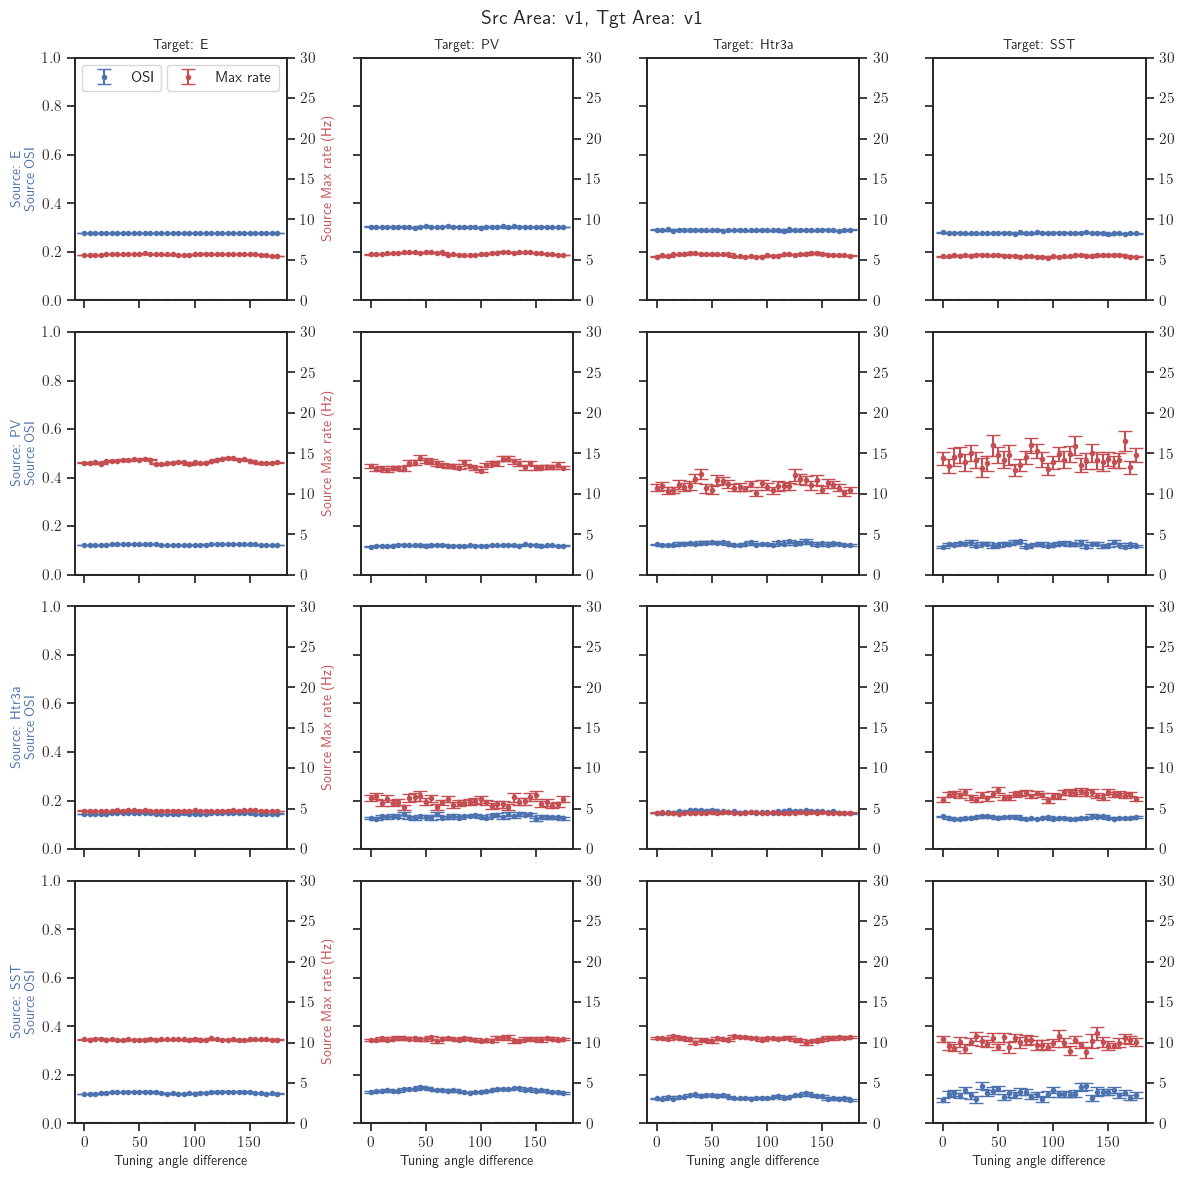

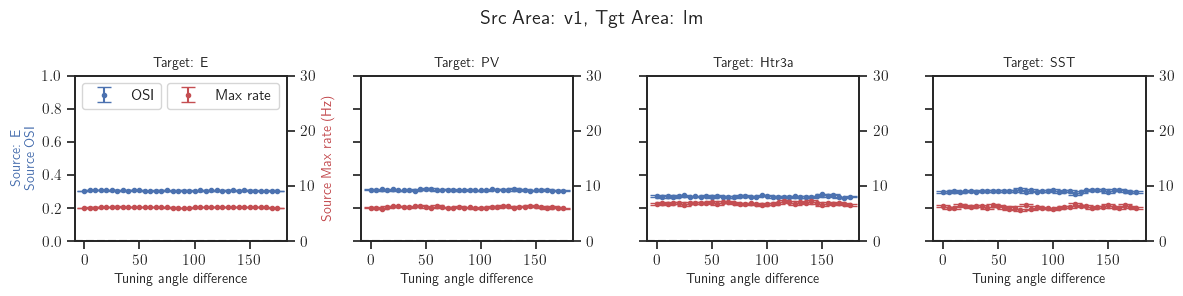

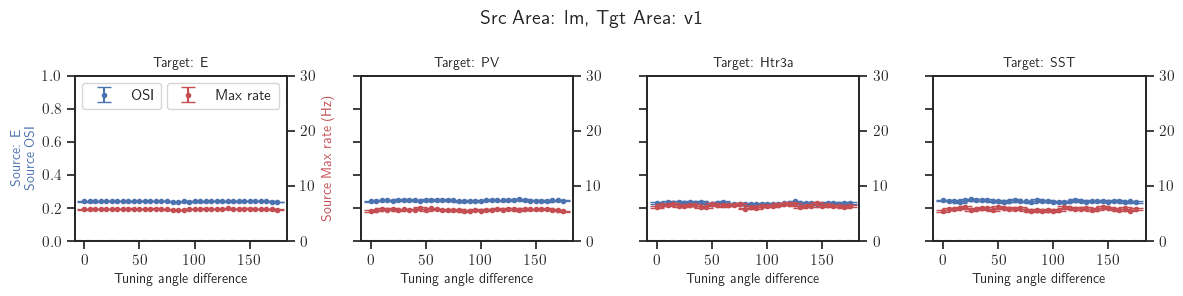

/home/jgalvan/.conda/envs/predictive_coding_tf212/lib/python3.11/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/jgalvan/.conda/envs/predictive_coding_tf212/lib/python3.11/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


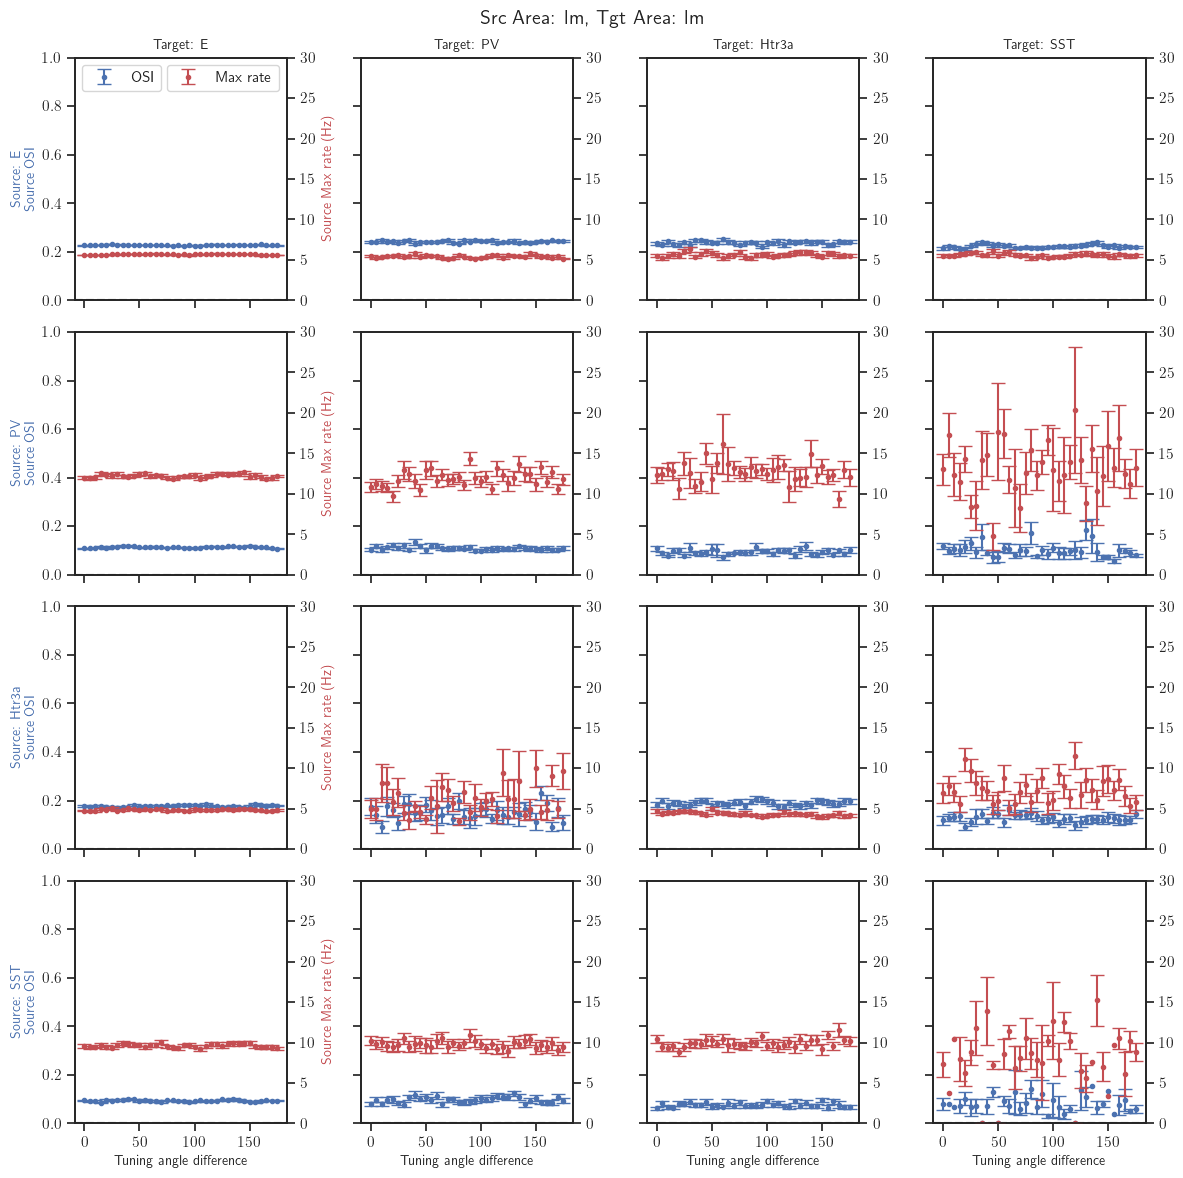

In [54]:
areas = ['v1', 'lm']
target_cell_types = ['E', 'PV', 'Htr3a', 'SST'] #['L2/3 Exc', 'L4 Exc', 'L5 Exc', 'L6 Exc']
source_cell_types = ['E', 'PV', 'Htr3a', 'SST']
num_subplots = len(source_cell_types)

for source_area in areas:
    source_df = df.loc[source_area] 
    for target_area in areas:
        target_df = df.loc[target_area]
        voltage_scale = (networks[target_area]['node_params']['V_th'] - networks[target_area]['node_params']['E_L']).astype(np.float32)
        # Get the initial weights and properly scale them down
        if source_area == target_area:
            variable_key = f'{target_area}_sparse_recurrent_weights:0'
            indices = networks[target_area]["synapses"]["indices"].astype(np.int32)
            source_cell_types = ['E', 'PV', 'Htr3a', 'SST']  
        else:
            variable_key = f'{target_area}_sparse_interarea_weights_{source_area}:0'
            indices = networks[target_area]['interarea_synapses'][source_area]["indices"].astype(np.int32)
            source_cell_types = ['E']
        # Calculate the voltage scale for node IDs
        node_type_ids = networks[target_area]['node_type_ids']
        
        fig, axs = plt.subplots(len(source_cell_types), 4, figsize=(12, 3*len(source_cell_types)), sharex=True, sharey='row')
        axs = axs.flatten()
        plot_index = 0
        for row, source_cell_type in enumerate(source_cell_types):
            source_tf_ids = source_df.index[(source_df['cell_type'].str.contains(source_cell_type)) & (source_df['region'] == 'core')].astype(np.int32).values
            for col, target_cell_type in enumerate(target_cell_types):
                target_tf_ids = target_df.index[(target_df['cell_type'].str.contains(target_cell_type)) & (target_df['region'] == 'core')].astype(np.int32).values
                # Create sets for fast lookup
                mask = fast_indices_masking(indices, target_tf_ids, source_tf_ids)
                selected_indices = indices[mask]
                target_indices = selected_indices[:, 0]
                source_indices = selected_indices[:, 1]
                source_osi = source_df.loc[source_indices, 'OSI'].values
                source_max_fr = source_df.loc[source_indices, 'max_mean_rate(Hz)'].values
                # Mask voltage_scale_node_ids first
                voltage_scale_node_ids = voltage_scale[node_type_ids[target_indices]]
                initial_value_masked = model_variables_dict['Initial'][variable_key][mask] * voltage_scale_node_ids
                final_value_masked = model_variables_dict['Restored'][variable_key][mask] * voltage_scale_node_ids
                # Calculate tuning angle differences
                source_tuning_angles = source_df.loc[source_indices, 'preferred_angle'].values
                target_tuning_angles = target_df.loc[target_indices, 'preferred_angle'].values
                tuning_angle_diff = np.abs(source_tuning_angles - target_tuning_angles)
                tuning_angle_diff = np.minimum(tuning_angle_diff, 360 - tuning_angle_diff)

                # take bins of 1 degree and average the weight values in the corresponding bin
                bins = np.arange(0, 181, 5)
                bin_indices = np.digitize(tuning_angle_diff, bins)
                bin_initial_values = np.zeros(len(bins) - 1)
                bin_initial_errors = np.zeros(len(bins) - 1)  # Array to store the standard error of the mean for each bin
                bin_final_values = np.zeros(len(bins) - 1)
                bin_final_errors = np.zeros(len(bins) - 1)  # Array to store the standard error of the mean for each bin
                for i in range(1, len(bins)):
                    max_fr_values_in_bin = source_max_fr[bin_indices == i]
                    if max_fr_values_in_bin.size > 0:
                        bin_initial_values[i-1] = np.mean(max_fr_values_in_bin)
                        std_dev_initial = np.std(max_fr_values_in_bin, ddof=1)
                        bin_initial_errors[i-1] = std_dev_initial / np.sqrt(max_fr_values_in_bin.size)
                    
                    osi_values_in_bin = source_osi[bin_indices == i]
                    if osi_values_in_bin.size > 0:
                        bin_final_values[i-1] = np.mean(osi_values_in_bin)
                        std_dev_final = np.std(osi_values_in_bin, ddof=1)
                        bin_final_errors[i-1] = std_dev_final / np.sqrt(osi_values_in_bin.size)
   
                # plot the average weight values with error bars
                axs[plot_index].errorbar(bins[:-1], bin_final_values, yerr=bin_final_errors, fmt='.', color='b', capsize=5, label='OSI')
                # Create a second y-axis for initial_values
                ax2 = axs[plot_index].twinx()
                ax2.errorbar(bins[:-1], bin_initial_values, yerr=bin_initial_errors, fmt='.', color='r', capsize=5, label=f'Max rate')
                axs[plot_index].axhline(y=0, color='black', linestyle='--')
                axs[plot_index].set_ylim(0, 1)
                ax2.set_ylim(0, 30)
                if row == 0:
                    axs[plot_index].set_title(f'Target: {target_cell_type}', fontsize=10)
                if col == 0:
                    axs[plot_index].set_ylabel(f'Source: {source_cell_type} \n Source OSI', fontsize=10, color='b') #, rotation=0, labelpad=40)
                    ax2.set_ylabel(f'Source Max rate (Hz)', fontsize=10, color='r')
                if row == len(source_cell_types) - 1:
                    axs[plot_index].set_xlabel(r'Tuning angle difference', fontsize=10)
                if row == 0 and col == 0:
                    axs[plot_index].legend(loc='upper left')
                    ax2.legend(loc='upper right')
                plot_index += 1

        fig.suptitle(f'Src Area: {source_area}, Tgt Area: {target_area}')
        plt.tight_layout()
        plt.show()